# Object Detection using TAO DetectNet_v2

Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where you use a model trained on one task and re-train to use it on a different task. 

Train Adapt Optimize (TAO) Toolkit  is a simple and easy-to-use Python based AI toolkit for taking purpose-built AI models and customizing them with users' own data.

<img align="center" src="https://developer.nvidia.com/sites/default/files/akamai/embedded-transfer-learning-toolkit-software-stack-1200x670px.png" width="1080"> 

## Learning Objectives
In this notebook, you will learn how to leverage the simplicity and convenience of TAO to:

* Take a pretrained resnet18 model and train a ResNet-18 DetectNet_v2 model on the KITTI dataset
* Prune the trained detectnet_v2 model
* Retrain the pruned model to recover lost accuracy
* Export the pruned model
* Quantize the pruned model using QAT
* Run Inference on the trained model
* Export the pruned, quantized and retrained model to a .etlt file for deployment to DeepStream
* Run inference on the exported. etlt model to verify deployment using TensorRT

### Table of Contents

This notebook shows an example usecase of Object Detection using DetectNet_v2 in the Train Adapt Optimize (TAO) Toolkit.

0. [Set up env variables and map drives](#head-0)
1. [Install the TAO Launcher](#head-1)
1. [Prepare dataset and pre-trained model](#head-2)
    1. [Download the dataset](#head-2-1)
    1. [Verify downloaded dataset](#head-2-2)
    1. [Prepare tfrecords from kitti format dataset](#head-2-3)
    2. [Download pre-trained model](#head-2-4)
2. [Provide training specification](#head-3)
3. [Run TAO training](#head-4)
4. [Evaluate trained models](#head-5)
5. [Prune trained models](#head-6)
6. [Retrain pruned models](#head-7)
7. [Evaluate retrained model](#head-8)
8. [Visualize inferences](#head-9)
9. [Model Export](#head-10)
    1. [Int8 Optimization](#head-10-1)
    2. [Generate TensorRT engine](#head-10-2)
10. [Verify Deployed Model](#head-11)
    1. [Inference using TensorRT engine](#head-11-1)
11. [QAT workflow](#head-12)
    1. [Convert pruned model to QAT and retrain](#head-12-1)
    2. [Evaluate QAT converted model](#head-12-2)
    3. [Export QAT trained model to int8](#head-12-3)
    4. [Evaluate a QAT trained model using the exported TensorRT engine](#head-12-4)
    5. [Inference using QAT engine](#head-12-5)

## 0. Set up env variables and map drives <a class="anchor" id="head-0"></a>
When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

The following notebook requires the user to set an env variable called the `$LOCAL_PROJECT_DIR` as the path to the users workspace. Please note that the dataset to run this notebook is expected to reside in the `$LOCAL_PROJECT_DIR/data`, while the TAO experiment generated collaterals will be output to `$LOCAL_PROJECT_DIR/detectnet_v2`. More information on how to set up the dataset and the supported steps in the TAO workflow are provided in the subsequent cells.

*Note: Please make sure to remove any stray artifacts/files from the `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` paths as mentioned below, that may have been generated from previous experiments. Having checkpoint files etc may interfere with creating a training graph for a new experiment.*

*Note: This notebook currently is by default set up to run training using 1 GPU. To use more GPU's please update the env variable `$NUM_GPUS` accordingly*

In [3]:
# Setting up env variables for cleaner command line commands.
import os

%env KEY=tlt_encode
%env NUM_GPUS=1
%env USER_EXPERIMENT_DIR=/workspace/tao-experiments/detectnet_v2
%env DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data

# Set this path if you don't run the notebook from the samples directory.
# %env NOTEBOOK_ROOT=~/tao-samples/detectnet_v2

# Please define this local project directory that needs to be mapped to the TAO docker session.
# The dataset expected to be present in $LOCAL_PROJECT_DIR/data, while the results for the steps
# in this notebook will be stored at $LOCAL_PROJECT_DIR/detectnet_v2
# !PLEASE MAKE SURE TO UPDATE THIS PATH!.

os.environ["LOCAL_PROJECT_DIR"] = '/home/diego/tao/cv_samples_v1.2.0/detectnet_v2/workspace/tao-experiments'

os.environ["LOCAL_DATA_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "data"
)
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "detectnet_v2"
)

# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("NOTEBOOK_ROOT", os.getcwd()),
    "specs"
)
%env SPECS_DIR=/workspace/tao-experiments/detectnet_v2/specs

# Showing list of specification files.
!ls -rlt $LOCAL_SPECS_DIR
!ls -rlt $LOCAL_PROJECT_DIR
!ls -rlt $LOCAL_DATA_DIR
!ls -rlt $LOCAL_EXPERIMENT_DIR
!ls -rlt $NOTEBOOK_ROOT
!ls -rlt $USER_EXPERIMENT_DIR

env: KEY=tlt_encode
env: NUM_GPUS=1
env: USER_EXPERIMENT_DIR=/workspace/tao-experiments/detectnet_v2
env: DATA_DOWNLOAD_DIR=/workspace/tao-experiments/data
env: SPECS_DIR=/workspace/tao-experiments/detectnet_v2/specs
total 44
-rw-rw-r-- 1 diego diego   310 Aug 24 23:51 detectnet_v2_tfrecords_kitti_trainval.txt
-rw-rw-r-- 1 diego diego  5557 Aug 24 23:51 detectnet_v2_retrain_resnet18_kitti.txt
-rw-rw-r-- 1 diego diego  5620 Aug 24 23:51 detectnet_v2_retrain_resnet18_kitti_qat.txt
-rw-rw-r-- 1 diego diego  2406 Aug 24 23:51 detectnet_v2_inference_kitti_tlt.txt
-rw-rw-r-- 1 diego diego  2436 Aug 24 23:51 detectnet_v2_inference_kitti_etlt.txt
-rw-rw-r-- 1 diego diego  2445 Aug 24 23:51 detectnet_v2_inference_kitti_etlt_qat.txt
-rw-rw-r-- 1 diego diego 12287 Nov 27 11:33 detectnet_v2_train_resnet18_kitti.txt
total 12
drwxrwxr-x 5 diego diego 4096 Nov 27 11:19 data
drwxrwxr-x 2 diego diego 4096 Nov 27 11:25 ngccli
drwxrwxr-x 5 diego diego 4096 Nov 27 12:25 detectnet_v2
total 12
drwxrwxr-x 4 

The cell below maps the project directory on your local host to a workspace directory in the TAO docker instance, so that the data and the results are mapped from in and out of the docker. For more information please refer to the [launcher instance](https://docs.nvidia.com/tao/tao-toolkit/tao_launcher.html) in the user guide.

When running this cell on AWS, update the drive_map entry with the dictionary defined below, so that you don't have permission issues when writing data into folders created by the TAO docker.

```json
drive_map = {
    "Mounts": [
            # Mapping the data directory
            {
                "source": os.environ["LOCAL_PROJECT_DIR"],
                "destination": "/workspace/tao-experiments"
            },
            # Mapping the specs directory.
            {
                "source": os.environ["LOCAL_SPECS_DIR"],
                "destination": os.environ["SPECS_DIR"]
            },
        ],
    "DockerOptions": {
        "user": "{}:{}".format(os.getuid(), os.getgid())
    }
}
```

In [16]:
# Mapping up the local directories to the TAO docker.
import json
mounts_file = os.path.expanduser("~/.tao_mounts.json")

# Define the dictionary with the mapped drives
drive_map = {
    "Mounts": [
            # Mapping the data directory
            {
                "source": os.environ["LOCAL_PROJECT_DIR"],
                "destination": "/workspace/tao-experiments"
            },
            # Mapping the specs directory.
            {
                "source": os.environ["LOCAL_SPECS_DIR"],
                "destination": os.environ["SPECS_DIR"]
            },
        ],
    "DockerOptions": {
        "user": "{}:{}".format(os.getuid(), os.getgid())
    }
}

# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

In [17]:
!cat ~/.tao_mounts.json

{
    "Mounts": [
        {
            "source": "/home/diego/tao/cv_samples_v1.2.0/detectnet_v2/workspace/tao-experiments",
            "destination": "/workspace/tao-experiments"
        },
        {
            "source": "/home/diego/tao/cv_samples_v1.2.0/detectnet_v2/specs",
            "destination": "/workspace/tao-experiments/detectnet_v2/specs"
        }
    ],
    "DockerOptions": {
        "user": "1000:1000"
    }
}

## 1. Install the TAO launcher <a class="anchor" id="head-1"></a>
The TAO launcher is a python package distributed as a python wheel listed in the `nvidia-pyindex` python index. You may install the launcher by executing the following cell.

Please note that TAO Toolkit recommends users to run the TAO launcher in a virtual env with python 3.6.9. You may follow the instruction in this [page](https://virtualenvwrapper.readthedocs.io/en/latest/install.html) to set up a python virtual env using the `virtualenv` and `virtualenvwrapper` packages. Once you have setup virtualenvwrapper, please set the version of python to be used in the virtual env by using the `VIRTUALENVWRAPPER_PYTHON` variable. You may do so by running

```sh
export VIRTUALENVWRAPPER_PYTHON=/path/to/bin/python3.x
```
where x >= 6 and <= 8

We recommend performing this step first and then launching the notebook from the virtual environment. In addition to installing TAO python package, please make sure of the following software requirements:
* python >=3.6.9 < 3.8.x
* docker-ce > 19.03.5
* docker-API 1.40
* nvidia-container-toolkit > 1.3.0-1
* nvidia-container-runtime > 3.4.0-1
* nvidia-docker2 > 2.5.0-1
* nvidia-driver > 455+

Once you have installed the pre-requisites, please log in to the docker registry nvcr.io by following the command below

```sh
docker login nvcr.io
```

You will be trigerred to enter a username and password. The username is `$oauthtoken` and the password is the API key generated from `ngc.nvidia.com`. Please follow the instructions in the [NGC setup guide](https://docs.nvidia.com/ngc/ngc-overview/index.html#generating-api-key) to generate your own API key.

In [6]:
# SKIP this step IF you have already installed the TAO launcher wheel.
!pip3 install nvidia-pyindex
!pip3 install nvidia-tao

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [19]:
# View the versions of the TAO launcher
!tao info

Configuration of the TAO Toolkit Instance
dockers: ['nvidia/tao/tao-toolkit-tf', 'nvidia/tao/tao-toolkit-pyt', 'nvidia/tao/tao-toolkit-lm']
format_version: 2.0
toolkit_version: 3.21.11
published_date: 11/08/2021


## 2. Prepare dataset and pre-trained model <a class="anchor" id="head-2"></a>

We will be using the kitti object detection dataset for this example. To find more details, please visit http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d. Please download both, the left color images of the object dataset from [here](http://www.cvlibs.net/download.php?file=data_object_image_2.zip) and, the training labels for the object dataset from [here](http://www.cvlibs.net/download.php?file=data_object_label_2.zip), and place the zip files in `$LOCAL_DATA_DIR`

The data will then be extracted to have
* training images in `$LOCAL_DATA_DIR/training/image_2`
* training labels in `$LOCAL_DATA_DIR/training/label_2`
* testing images in `$LOCAL_DATA_DIR/testing/image_2`

You may use this notebook with your own dataset as well. To use this example with your own dataset, please follow the same directory structure as mentioned below.

*Note: There are no labels for the testing images, therefore we use it just to visualize inferences for the trained model.*

### B. Verify downloaded dataset <a class="anchor" id="head-2-2"></a>

In [8]:
# verify
import os

DATA_DIR = os.environ.get('LOCAL_DATA_DIR')
num_training_images = len(os.listdir(os.path.join(DATA_DIR, "training/image_2")))
num_training_labels = len(os.listdir(os.path.join(DATA_DIR, "training/label_2")))
num_testing_images = len(os.listdir(os.path.join(DATA_DIR, "testing/image_2")))
print("Number of images in the train/val set. {}".format(num_training_images))
print("Number of labels in the train/val set. {}".format(num_training_labels))
print("Number of images in the test set. {}".format(num_testing_images))

Number of images in the train/val set. 100
Number of labels in the train/val set. 100
Number of images in the test set. 400


In [9]:
# Sample kitti label.
!cat $LOCAL_DATA_DIR/training/label_2/90.txt

### C. Prepare tf records from kitti format dataset <a class="anchor" id="head-2-3"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the detectnet_v2 dataset_convert 

*Note: TfRecords only need to be generated once.*

In [10]:
print("TFrecords conversion spec file for kitti training")
!cat $LOCAL_SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt

TFrecords conversion spec file for kitti training
kitti_config {
  root_directory_path: "/workspace/tao-experiments/data/training"
  image_dir_name: "image_2"
  label_dir_name: "label_2"
  image_extension: ".png"
  partition_mode: "random"
  num_partitions: 2
  val_split: 14
  num_shards: 10
}
image_directory_path: "/workspace/tao-experiments/data/training"


In [11]:
# Creating a new directory for the output tfrecords dump.
print("Converting Tfrecords for kitti trainval dataset")
!mkdir -p $LOCAL_DATA_DIR/tfrecords && rm -rf $LOCAL_DATA_DIR/tfrecords/*
!tao detectnet_v2 dataset_convert \
                  -d $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt \
                  -o $DATA_DOWNLOAD_DIR/tfrecords/kitti_trainval/kitti_trainval

Converting Tfrecords for kitti trainval dataset
2021-11-27 11:19:21,805 [INFO] root: Registry: ['nvcr.io']
2021-11-27 11:19:21,856 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3
2021-11-27 11:19:21,876 [INFO] tlt.components.docker_handler.docker_handler: The required docker doesn't exist locally/the manifest has changed. Pulling a new docker.
2021-11-27 11:19:21,876 [INFO] tlt.components.docker_handler.docker_handler: Pulling the required container. This may take several minutes if you're doing this for the first time. Please wait here.
...
Pulling from repository: nvcr.io/nvidia/tao/tao-toolkit-tf
2021-11-27 11:21:54,043 [INFO] tlt.components.docker_handler.docker_handler: Container pull complete.
2021-11-27 11:21:54,043 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":

2021-11-27 11:22:03,858 [INFO] tlt.components.docker_handler.docker_handler: Stopping container.


In [10]:
!ls -rlt $LOCAL_DATA_DIR/tfrecords/kitti_trainval/

total 476
-rw-r--r-- 1 root root  3855 Nov 27 11:22 kitti_trainval-fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root  6762 Nov 27 11:22 kitti_trainval-fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 root root  3428 Nov 27 11:22 kitti_trainval-fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 root root  4717 Nov 27 11:22 kitti_trainval-fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 root root  7247 Nov 27 11:22 kitti_trainval-fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 root root  8552 Nov 27 11:22 kitti_trainval-fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 root root  8175 Nov 27 11:22 kitti_trainval-fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 root root  7877 Nov 27 11:22 kitti_trainval-fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 root root  8428 Nov 27 11:22 kitti_trainval-fold-000-of-002-shard-00008-of-00010
-rw-r--r-- 1 root root 14982 Nov 27 11:22 kitti_trainval-fold-000-of-002-shard-00009-of-00010
-rw-r--r-- 1 root root 40158 Nov 27 11:22 kitti_tr

### D. Download pre-trained model <a class="anchor" id="head-2-4"></a>
Download the correct pretrained model from the NGC model registry for your experiment. Please note that for DetectNet_v2, the input is expected to be 0-1 normalized with input channels in RGB order. Therefore, for optimum results please download model templates from `nvidia/tao/pretrained_detectnet_v2`. The templates are now organized as version strings. For example, to download a resnet18 model suitable for detectnet please resolve to the ngc object shown as `nvidia/tao/pretrained_detectnet_v2:resnet18`. 

All other models are in BGR order expect input preprocessing with mean subtraction and input channels. Using them as pretrained weights may result in suboptimal performance.

You may also use this notebook with the following purpose-built pretrained models 
* [PeopleNet](https://ngc.nvidia.com/catalog/models/nvidia:tao:peoplenet)
* [TrafficCamNet](https://ngc.nvidia.com/catalog/models/nvidia:tao:trafficcamnet)
* [DashCamNet](https://ngc.nvidia.com/catalog/models/nvidia:tao:dashcamnet)
* [FaceDetect-IR](https://ngc.nvidia.com/catalog/models/nvidia:tao:facedetectir) 

In [13]:
# Installing NGC CLI on the local machine.
## Download and install
%env CLI=ngccli_cat_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli

# Remove any previously existing CLI installations
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_cat_linux.zip
--2021-11-27 11:25:23--  https://ngc.nvidia.com/downloads/ngccli_cat_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 13.224.212.50, 13.224.212.54, 13.224.212.128, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|13.224.212.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25122189 (24M) [application/zip]
Saving to: ‘/home/diego/tao/cv_samples_v1.2.0/detectnet_v2/workspace/tao-experiments/ngccli/ngccli_cat_linux.zip’

ngccli_cat_linux.zi 100%[===================>]  23.96M  31.3MB/s    in 0.8s    

2021-11-27 11:25:24 (31.3 MB/s) - ‘/home/diego/tao/cv_samples_v1.2.0/detectnet_v2/workspace/tao-experiments/ngccli/ngccli_cat_linux.zip’ saved [25122189/25122189]

Archive:  /home/diego/tao/cv_samples_v1.2.0/detectnet_v2/workspace/tao-experiments/ngccli/ngccli_cat_linux.zip
  inflating: /home/diego/tao/cv_samples_v1.2.0/detectnet_v2/workspace/tao-experiments/ngccli/ngc  
 extracting: /home/diego/tao/cv_samples_v1.2.0/detectnet_v2

In [14]:
# List models available in the model registry.
!ngc registry model list nvidia/tao/pretrained_detectnet_v2:*

[{
    "accuracyReached": 82.6,
    "batchSize": 1,
    "createdByUser": "n90fe0en2gvll5957fel7u75sg",
    "createdDate": "2021-08-24T00:31:54.266Z",
    "description": "",
    "gpuModel": "V100",
    "memoryFootprint": "153.8",
    "numberOfEpochs": 80,
    "status": "UPLOAD_COMPLETE",
    "totalFileCount": 1,
    "totalSizeInBytes": 161239496,
    "versionId": "vgg19"
},{
    "accuracyReached": 82.2,
    "batchSize": 1,
    "createdByUser": "n90fe0en2gvll5957fel7u75sg",
    "createdDate": "2021-08-24T00:31:36.645Z",
    "description": "",
    "gpuModel": "V100",
    "memoryFootprint": "113.2",
    "numberOfEpochs": 80,
    "status": "UPLOAD_COMPLETE",
    "totalFileCount": 1,
    "totalSizeInBytes": 118697088,
    "versionId": "vgg16"
},{
    "accuracyReached": 65.67,
    "batchSize": 1,
    "createdByUser": "n90fe0en2gvll5957fel7u75sg",
    "createdDate": "2021-08-24T00:32:39.494Z",
    "description": "",
    "gpuModel": "V100",
    "memoryFootprint": "6.5",
    "numberOfEpochs": 80

In [15]:
# Create the target destination to download the model.
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/

In [16]:
# Download the pretrained model from NGC
!ngc registry model download-version nvidia/tao/pretrained_detectnet_v2:resnet18 \
    --dest $LOCAL_EXPERIMENT_DIR/pretrained_resnet18

{
    "download_end": "2021-11-27 11:25:50.754975",
    "download_start": "2021-11-27 11:25:42.745406",
    "download_time": "8s",
    "files_downloaded": 1,
    "local_path": "/home/diego/tao/cv_samples_v1.2.0/detectnet_v2/workspace/tao-experiments/detectnet_v2/pretrained_resnet18/pretrained_detectnet_v2_vresnet18",
    "size_downloaded": "82.28 MB",
    "status": "Completed",
    "transfer_id": "pretrained_detectnet_v2_vresnet18"
}


In [11]:
!ls -rlt $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/pretrained_detectnet_v2_vresnet18

total 91160
-rw------- 1 diego diego 93345248 Nov 27 11:25 resnet18.hdf5


## 3. Provide training specification <a class="anchor" id="head-3"></a>
* Tfrecords for the train datasets
    * To use the newly generated tfrecords, update the dataset_config parameter in the spec file at `$SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt` 
    * Update the fold number to use for evaluation. In case of random data split, please use fold `0` only
    * For sequence-wise split, you may use any fold generated from the dataset convert tool
* Pre-trained models
* Augmentation parameters for on the fly data augmentation
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [12]:
!cat $LOCAL_SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/tao-experiments/data/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/tao-experiments/data/training"
  }
  image_extension: "png"
  target_class_mapping {
    key: "ceiling"
    value: "ceiling"
  }
  target_class_mapping {
    key: "floor"
    value: "floor"
  }
  target_class_mapping {
    key: "palette"
    value: "palette"
  }
  target_class_mapping {
    key: "pillar"
    value: "pillar"
  }
  target_class_mapping {
    key: "pushcart"
    value: "pushcart"
  }
  target_class_mapping {
    key: "rackframe"
    value: "rackframe"
  }
  target_class_mapping {
    key: "rackshelf"
    value: "rackshelf"
  }
  target_class_mapping {
    key: "wall"
    value: "wall"
  }
  target_class_mapping {
    key: "cardbox"
    value: "cardbox"
  }
  validation_fold: 0
}
augmentation_config {
  preprocessing {
    output_image_width: 1248
    output_image_height: 384
    min_bbox_width: 1.0
    min

## 4. Run TAO training <a class="anchor" id="head-4"></a>
* Provide the sample spec file and the output directory location for models

*Note: The training may take hours to complete. Also, the remaining notebook, assumes that the training was done in single-GPU mode. When run in multi-GPU mode, please expect to update the pruning and inference steps with new pruning thresholds and updated parameters in the clusterfile.json accordingly for optimum performance.*

*Detectnet_v2 now supports restart from checkpoint. Incase the training job is killed prematurely, you may resume training from the closest checkpoint by simply re-running the **same** command line. Please do make sure to use the <u>**same number of GPUs**</u> when restarting the training.*

*When running the training with NUM_GPUs>1, you may need to modify the `batc_size_per_gpu` and `learning_rate` to get similar mAP as a 1GPU training run. In most cases, scaling down the batch-size by a factor of NUM_GPU's or scaling up the learning rate by a factor of NUM_GPU's would be a good place to start.* 

In [20]:
!tao detectnet_v2 train -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
                        -k $KEY \
                        -n resnet18_detector \
                        --gpus $NUM_GPUS

2021-11-27 16:31:00,082 [INFO] root: Registry: ['nvcr.io']
2021-11-27 16:31:00,127 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-72jja2oo because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2021-11-27 21:31:04,350 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/cost_function/cost_auto_weight_hook.py:43: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.


2021-11-27


2021-11-27 21:31:05,788 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.


2021-11-27 21:31:05,789 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.


2021-11-27 21:31:05,989 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

2021-11-27 21:31:09,663 [INFO] iva.detectnet_v2.objectives.bbox_objective: Default L1 loss function will be used.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected t


2021-11-27 21:31:09,715 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

2021-11-27 21:31:09,747 [WARNING] tensorflow: Entity <bound method DriveNetTFRecordsParser.__call__ of <iva.detectnet_v2.dataloader.drivenet_dataloader.DriveNetTFRecordsParser object at 0x7fb0548cc7b8>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Unable to locate the source code of <bound method DriveNetTFRecordsParser.__call__ of <iva.detectnet_v2.dataloader.drivenet_dataloader.DriveNetTFRecordsParser object at 0x7fb0548cc7b8>>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you

2021-11-27 21:31:11,937 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Serial augmentation enabled = False
2021-11-27 21:31:11,937 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Pseudo sharding enabled = False
2021-11-27 21:31:11,937 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Max Image Dimensions (all sources): (0, 0)
2021-11-27 21:31:11,938 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: number of cpus: 16, io threads: 32, compute threads: 16, buffered batches: 4
2021-11-27 21:31:11,938 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: total dataset size 14, number of sources: 1, batch size per gpu: 4, steps: 4
2021-11-27 21:31:11,944 [WARNING] tensorflow: Entity <bound method DriveNetTFRecordsParser.__call__ of <iva.detectnet_v2.dataloader.drivenet_dataloader.DriveNetTFRecordsParser object at 0x7fb0548cc780>> could not be transformed and will be executed as-is. Please report this 

INFO:tensorflow:Graph was finalized.
2021-11-27 21:31:14,169 [INFO] tensorflow: Graph was finalized.
INFO:tensorflow:Running local_init_op.
2021-11-27 21:31:15,298 [INFO] tensorflow: Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2021-11-27 21:31:15,678 [INFO] tensorflow: Done running local_init_op.
INFO:tensorflow:Saving checkpoints for step-0.
2021-11-27 21:31:20,052 [INFO] tensorflow: Saving checkpoints for step-0.
INFO:tensorflow:epoch = 0.0, learning_rate = 4.9999994e-06, loss = 0.083847225, step = 0
2021-11-27 21:31:33,730 [INFO] tensorflow: epoch = 0.0, learning_rate = 4.9999994e-06, loss = 0.083847225, step = 0
2021-11-27 21:31:33,731 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 0/120: loss: 0.08385 learning rate: 0.00000 Time taken: 0:00:00 ETA: 0:00:00
2021-11-27 21:31:33,731 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 0.964
INFO:tensorflow:global_step/sec: 1.4339
2021-11-27 21:31:35,125 [INFO] tensorflow: global_ste

INFO:tensorflow:global_step/sec: 14.6786
2021-11-27 21:31:39,618 [INFO] tensorflow: global_step/sec: 14.6786
INFO:tensorflow:global_step/sec: 14.6051
2021-11-27 21:31:39,755 [INFO] tensorflow: global_step/sec: 14.6051
2021-11-27 21:31:39,756 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 3/120: loss: 0.07809 learning rate: 0.00002 Time taken: 0:00:01.501290 ETA: 0:02:55.650968
INFO:tensorflow:global_step/sec: 14.9706
2021-11-27 21:31:39,888 [INFO] tensorflow: global_step/sec: 14.9706
INFO:tensorflow:global_step/sec: 14.2494
2021-11-27 21:31:40,029 [INFO] tensorflow: global_step/sec: 14.2494
INFO:tensorflow:global_step/sec: 15.1121
2021-11-27 21:31:40,161 [INFO] tensorflow: global_step/sec: 15.1121
INFO:tensorflow:global_step/sec: 14.9982
2021-11-27 21:31:40,294 [INFO] tensorflow: global_step/sec: 14.9982
2021-11-27 21:31:40,295 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.905
INFO:tensorflow:global_step/sec: 14.8274
2021-11-27 21:31:40,429 [INFO]

INFO:tensorflow:global_step/sec: 14.2694
2021-11-27 21:31:47,616 [INFO] tensorflow: global_step/sec: 14.2694
INFO:tensorflow:global_step/sec: 14.2976
2021-11-27 21:31:47,756 [INFO] tensorflow: global_step/sec: 14.2976
INFO:tensorflow:global_step/sec: 14.8727
2021-11-27 21:31:47,891 [INFO] tensorflow: global_step/sec: 14.8727
INFO:tensorflow:global_step/sec: 13.9839
2021-11-27 21:31:48,034 [INFO] tensorflow: global_step/sec: 13.9839
INFO:tensorflow:global_step/sec: 14.4957
2021-11-27 21:31:48,172 [INFO] tensorflow: global_step/sec: 14.4957
INFO:tensorflow:global_step/sec: 14.6333
2021-11-27 21:31:48,308 [INFO] tensorflow: global_step/sec: 14.6333
INFO:tensorflow:global_step/sec: 14.3759
2021-11-27 21:31:48,448 [INFO] tensorflow: global_step/sec: 14.3759
INFO:tensorflow:global_step/sec: 14.4949
2021-11-27 21:31:48,586 [INFO] tensorflow: global_step/sec: 14.4949
INFO:tensorflow:global_step/sec: 14.3527
2021-11-27 21:31:48,725 [INFO] tensorflow: global_step/sec: 14.3527
2021-11-27 21:31:48

INFO:tensorflow:global_step/sec: 14.595
2021-11-27 21:31:57,893 [INFO] tensorflow: global_step/sec: 14.595
2021-11-27 21:31:57,966 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 57.864
INFO:tensorflow:global_step/sec: 14.0557
2021-11-27 21:31:58,036 [INFO] tensorflow: global_step/sec: 14.0557
INFO:tensorflow:global_step/sec: 15.359
2021-11-27 21:31:58,166 [INFO] tensorflow: global_step/sec: 15.359
INFO:tensorflow:global_step/sec: 14.7587
2021-11-27 21:31:58,302 [INFO] tensorflow: global_step/sec: 14.7587
INFO:tensorflow:global_step/sec: 13.7878
2021-11-27 21:31:58,447 [INFO] tensorflow: global_step/sec: 13.7878
INFO:tensorflow:global_step/sec: 14.0349
2021-11-27 21:31:58,589 [INFO] tensorflow: global_step/sec: 14.0349
2021-11-27 21:31:58,590 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 14/120: loss: 0.00258 learning rate: 0.00050 Time taken: 0:00:01.511611 ETA: 0:02:40.230815
INFO:tensorflow:global_step/sec: 15.0277
2021-11-27 21:31:58,722 [INFO] te

INFO:tensorflow:global_step/sec: 14.1046
2021-11-27 21:32:05,919 [INFO] tensorflow: global_step/sec: 14.1046
INFO:tensorflow:global_step/sec: 14.5612
2021-11-27 21:32:06,056 [INFO] tensorflow: global_step/sec: 14.5612
INFO:tensorflow:global_step/sec: 13.5439
2021-11-27 21:32:06,204 [INFO] tensorflow: global_step/sec: 13.5439
2021-11-27 21:32:06,205 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 19/120: loss: 0.00155 learning rate: 0.00050 Time taken: 0:00:01.529584 ETA: 0:02:34.488001
INFO:tensorflow:global_step/sec: 14.3055
2021-11-27 21:32:06,344 [INFO] tensorflow: global_step/sec: 14.3055
INFO:tensorflow:global_step/sec: 14.9522
2021-11-27 21:32:06,477 [INFO] tensorflow: global_step/sec: 14.9522
INFO:tensorflow:global_step/sec: 15.0328
2021-11-27 21:32:06,610 [INFO] tensorflow: global_step/sec: 15.0328
2021-11-27 21:32:06,611 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 57.729
INFO:tensorflow:global_step/sec: 14.9099
2021-11-27 21:32:06,745 [INFO

INFO:tensorflow:global_step/sec: 12.8793
2021-11-27 21:32:16,209 [INFO] tensorflow: global_step/sec: 12.8793
2021-11-27 21:32:16,209 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 24/120: loss: 0.00166 learning rate: 0.00050 Time taken: 0:00:01.541709 ETA: 0:02:28.004082
INFO:tensorflow:global_step/sec: 14.3241
2021-11-27 21:32:16,348 [INFO] tensorflow: global_step/sec: 14.3241
INFO:tensorflow:global_step/sec: 14.7039
2021-11-27 21:32:16,484 [INFO] tensorflow: global_step/sec: 14.7039
INFO:tensorflow:global_step/sec: 14.7066
2021-11-27 21:32:16,620 [INFO] tensorflow: global_step/sec: 14.7066
INFO:tensorflow:global_step/sec: 14.8244
2021-11-27 21:32:16,755 [INFO] tensorflow: global_step/sec: 14.8244
INFO:tensorflow:global_step/sec: 14.7138
2021-11-27 21:32:16,891 [INFO] tensorflow: global_step/sec: 14.7138
INFO:tensorflow:global_step/sec: 14.6269
2021-11-27 21:32:17,028 [INFO] tensorflow: global_step/sec: 14.6269
INFO:tensorflow:global_step/sec: 14.7153
2021-11-27 21:

INFO:tensorflow:global_step/sec: 14.2586
2021-11-27 21:32:24,519 [INFO] tensorflow: global_step/sec: 14.2586
2021-11-27 21:32:24,586 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 57.456
INFO:tensorflow:global_step/sec: 14.6974
2021-11-27 21:32:24,655 [INFO] tensorflow: global_step/sec: 14.6974
INFO:tensorflow:global_step/sec: 14.0924
2021-11-27 21:32:24,797 [INFO] tensorflow: global_step/sec: 14.0924
INFO:tensorflow:global_step/sec: 13.8409
2021-11-27 21:32:24,942 [INFO] tensorflow: global_step/sec: 13.8409
INFO:tensorflow:global_step/sec: 13.9689
2021-11-27 21:32:25,085 [INFO] tensorflow: global_step/sec: 13.9689
INFO:tensorflow:global_step/sec: 14.7609
2021-11-27 21:32:25,220 [INFO] tensorflow: global_step/sec: 14.7609
INFO:tensorflow:Saving checkpoints for step-660.
2021-11-27 21:32:25,291 [INFO] tensorflow: Saving checkpoints for step-660.
2021-11-27 21:32:27,694 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 3, 0.00s/step
Matching predictions to ground tr

INFO:tensorflow:global_step/sec: 14.8988
2021-11-27 21:32:44,164 [INFO] tensorflow: global_step/sec: 14.8988
INFO:tensorflow:global_step/sec: 14.5407
2021-11-27 21:32:44,301 [INFO] tensorflow: global_step/sec: 14.5407
INFO:tensorflow:global_step/sec: 14.3613
2021-11-27 21:32:44,440 [INFO] tensorflow: global_step/sec: 14.3613
2021-11-27 21:32:44,441 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 34/120: loss: 0.00140 learning rate: 0.00050 Time taken: 0:00:01.515900 ETA: 0:02:10.367371
2021-11-27 21:32:44,504 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.017
INFO:tensorflow:global_step/sec: 15.458
2021-11-27 21:32:44,570 [INFO] tensorflow: global_step/sec: 15.458
INFO:tensorflow:global_step/sec: 14.9633
2021-11-27 21:32:44,703 [INFO] tensorflow: global_step/sec: 14.9633
INFO:tensorflow:global_step/sec: 14.3656
2021-11-27 21:32:44,843 [INFO] tensorflow: global_step/sec: 14.3656
INFO:tensorflow:global_step/sec: 14.0648
2021-11-27 21:32:44,985 [INFO] 

INFO:tensorflow:global_step/sec: 14.5099
2021-11-27 21:32:52,360 [INFO] tensorflow: global_step/sec: 14.5099
INFO:tensorflow:global_step/sec: 13.5787
2021-11-27 21:32:52,508 [INFO] tensorflow: global_step/sec: 13.5787
INFO:tensorflow:global_step/sec: 14.1389
2021-11-27 21:32:52,649 [INFO] tensorflow: global_step/sec: 14.1389
INFO:tensorflow:global_step/sec: 13.9978
2021-11-27 21:32:52,792 [INFO] tensorflow: global_step/sec: 13.9978
INFO:tensorflow:global_step/sec: 14.7987
2021-11-27 21:32:52,927 [INFO] tensorflow: global_step/sec: 14.7987
INFO:tensorflow:global_step/sec: 15.0165
2021-11-27 21:32:53,060 [INFO] tensorflow: global_step/sec: 15.0165
INFO:tensorflow:global_step/sec: 14.6274
2021-11-27 21:32:53,197 [INFO] tensorflow: global_step/sec: 14.6274
2021-11-27 21:32:53,198 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 56.824
INFO:tensorflow:global_step/sec: 14.5524
2021-11-27 21:32:53,334 [INFO] tensorflow: global_step/sec: 14.5524
INFO:tensorflow:global_step/sec: 1

INFO:tensorflow:global_step/sec: 14.887
2021-11-27 21:33:10,591 [INFO] tensorflow: global_step/sec: 14.887
INFO:tensorflow:global_step/sec: 14.6449
2021-11-27 21:33:10,727 [INFO] tensorflow: global_step/sec: 14.6449
INFO:tensorflow:global_step/sec: 14.5802
2021-11-27 21:33:10,864 [INFO] tensorflow: global_step/sec: 14.5802
INFO:tensorflow:global_step/sec: 14.649
2021-11-27 21:33:11,001 [INFO] tensorflow: global_step/sec: 14.649
INFO:tensorflow:global_step/sec: 15.0163
2021-11-27 21:33:11,134 [INFO] tensorflow: global_step/sec: 15.0163
INFO:tensorflow:global_step/sec: 13.89
2021-11-27 21:33:11,278 [INFO] tensorflow: global_step/sec: 13.89
2021-11-27 21:33:11,279 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 44/120: loss: 0.00138 learning rate: 0.00050 Time taken: 0:00:01.502695 ETA: 0:01:54.204808
INFO:tensorflow:global_step/sec: 14.5376
2021-11-27 21:33:11,416 [INFO] tensorflow: global_step/sec: 14.5376
INFO:tensorflow:global_step/sec: 14.9906
2021-11-27 21:33:11,54

INFO:tensorflow:global_step/sec: 15.5876
2021-11-27 21:33:18,997 [INFO] tensorflow: global_step/sec: 15.5876
INFO:tensorflow:global_step/sec: 14.0888
2021-11-27 21:33:19,139 [INFO] tensorflow: global_step/sec: 14.0888
INFO:tensorflow:global_step/sec: 14.3642
2021-11-27 21:33:19,278 [INFO] tensorflow: global_step/sec: 14.3642
INFO:tensorflow:global_step/sec: 14.677
2021-11-27 21:33:19,415 [INFO] tensorflow: global_step/sec: 14.677
INFO:tensorflow:global_step/sec: 14.908
2021-11-27 21:33:19,549 [INFO] tensorflow: global_step/sec: 14.908
INFO:tensorflow:global_step/sec: 14.4925
2021-11-27 21:33:19,687 [INFO] tensorflow: global_step/sec: 14.4925
INFO:tensorflow:global_step/sec: 14.0443
2021-11-27 21:33:19,829 [INFO] tensorflow: global_step/sec: 14.0443
INFO:tensorflow:global_step/sec: 14.4353
2021-11-27 21:33:19,968 [INFO] tensorflow: global_step/sec: 14.4353
INFO:tensorflow:global_step/sec: 14.8685
2021-11-27 21:33:20,102 [INFO] tensorflow: global_step/sec: 14.8685
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 15.1313
2021-11-27 21:33:35,675 [INFO] tensorflow: global_step/sec: 15.1313
INFO:tensorflow:global_step/sec: 14.0623
2021-11-27 21:33:35,817 [INFO] tensorflow: global_step/sec: 14.0623
INFO:tensorflow:global_step/sec: 14.245
2021-11-27 21:33:35,958 [INFO] tensorflow: global_step/sec: 14.245
INFO:tensorflow:global_step/sec: 14.8979
2021-11-27 21:33:36,092 [INFO] tensorflow: global_step/sec: 14.8979
INFO:tensorflow:global_step/sec: 13.5534
2021-11-27 21:33:36,240 [INFO] tensorflow: global_step/sec: 13.5534
INFO:tensorflow:global_step/sec: 13.8358
2021-11-27 21:33:36,384 [INFO] tensorflow: global_step/sec: 13.8358
INFO:tensorflow:global_step/sec: 13.4675
2021-11-27 21:33:36,533 [INFO] tensorflow: global_step/sec: 13.4675
2021-11-27 21:33:36,534 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 54/120: loss: 0.00139 learning rate: 0.00050 Time taken: 0:00:01.544009 ETA: 0:01:41.904576
INFO:tensorflow:global_step/sec: 14.913
2021-11-27 21:33:

2021-11-27 21:33:44,161 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.454
INFO:tensorflow:global_step/sec: 14.9341
2021-11-27 21:33:44,228 [INFO] tensorflow: global_step/sec: 14.9341
INFO:tensorflow:global_step/sec: 14.5881
2021-11-27 21:33:44,365 [INFO] tensorflow: global_step/sec: 14.5881
INFO:tensorflow:global_step/sec: 14.4416
2021-11-27 21:33:44,503 [INFO] tensorflow: global_step/sec: 14.4416
INFO:tensorflow:global_step/sec: 14.8175
2021-11-27 21:33:44,638 [INFO] tensorflow: global_step/sec: 14.8175
INFO:tensorflow:global_step/sec: 14.8709
2021-11-27 21:33:44,773 [INFO] tensorflow: global_step/sec: 14.8709
INFO:tensorflow:global_step/sec: 14.5072
2021-11-27 21:33:44,911 [INFO] tensorflow: global_step/sec: 14.5072
INFO:tensorflow:global_step/sec: 15.1607
2021-11-27 21:33:45,042 [INFO] tensorflow: global_step/sec: 15.1607
INFO:tensorflow:global_step/sec: 15.0658
2021-11-27 21:33:45,175 [INFO] tensorflow: global_step/sec: 15.0658
INFO:tensorflow:global_step/sec: 1

INFO:tensorflow:global_step/sec: 14.4147
2021-11-27 21:34:00,972 [INFO] tensorflow: global_step/sec: 14.4147
INFO:tensorflow:global_step/sec: 14.5532
2021-11-27 21:34:01,110 [INFO] tensorflow: global_step/sec: 14.5532
2021-11-27 21:34:01,179 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.329
INFO:tensorflow:global_step/sec: 14.0159
2021-11-27 21:34:01,252 [INFO] tensorflow: global_step/sec: 14.0159
INFO:tensorflow:global_step/sec: 14.8762
2021-11-27 21:34:01,387 [INFO] tensorflow: global_step/sec: 14.8762
INFO:tensorflow:global_step/sec: 14.9651
2021-11-27 21:34:01,520 [INFO] tensorflow: global_step/sec: 14.9651
INFO:tensorflow:global_step/sec: 14.8619
2021-11-27 21:34:01,655 [INFO] tensorflow: global_step/sec: 14.8619
INFO:tensorflow:global_step/sec: 14.4586
2021-11-27 21:34:01,793 [INFO] tensorflow: global_step/sec: 14.4586
2021-11-27 21:34:01,794 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 64/120: loss: 0.00158 learning rate: 0.00050 Time tak

INFO:tensorflow:global_step/sec: 13.9285
2021-11-27 21:34:09,500 [INFO] tensorflow: global_step/sec: 13.9285
2021-11-27 21:34:09,501 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 69/120: loss: 0.00114 learning rate: 0.00050 Time taken: 0:00:01.539276 ETA: 0:01:18.503094
INFO:tensorflow:global_step/sec: 13.9658
2021-11-27 21:34:09,643 [INFO] tensorflow: global_step/sec: 13.9658
INFO:tensorflow:global_step/sec: 14.5352
2021-11-27 21:34:09,781 [INFO] tensorflow: global_step/sec: 14.5352
INFO:tensorflow:global_step/sec: 14.4218
2021-11-27 21:34:09,919 [INFO] tensorflow: global_step/sec: 14.4218
2021-11-27 21:34:09,920 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 57.232
INFO:tensorflow:global_step/sec: 14.9071
2021-11-27 21:34:10,054 [INFO] tensorflow: global_step/sec: 14.9071
INFO:tensorflow:global_step/sec: 15.1406
2021-11-27 21:34:10,186 [INFO] tensorflow: global_step/sec: 15.1406
INFO:tensorflow:global_step/sec: 14.9649
2021-11-27 21:34:10,319 [INFO

INFO:tensorflow:global_step/sec: 14.519
2021-11-27 21:34:25,583 [INFO] tensorflow: global_step/sec: 14.519
INFO:tensorflow:epoch = 73.36363636363636, learning_rate = 0.00049999997, loss = 0.0014130131, step = 1614 (5.101 sec)
2021-11-27 21:34:25,716 [INFO] tensorflow: epoch = 73.36363636363636, learning_rate = 0.00049999997, loss = 0.0014130131, step = 1614 (5.101 sec)
INFO:tensorflow:global_step/sec: 14.9241
2021-11-27 21:34:25,717 [INFO] tensorflow: global_step/sec: 14.9241
INFO:tensorflow:global_step/sec: 14.7477
2021-11-27 21:34:25,853 [INFO] tensorflow: global_step/sec: 14.7477
INFO:tensorflow:global_step/sec: 14.3344
2021-11-27 21:34:25,992 [INFO] tensorflow: global_step/sec: 14.3344
INFO:tensorflow:global_step/sec: 14.4996
2021-11-27 21:34:26,130 [INFO] tensorflow: global_step/sec: 14.4996
INFO:tensorflow:global_step/sec: 14.8608
2021-11-27 21:34:26,265 [INFO] tensorflow: global_step/sec: 14.8608
INFO:tensorflow:global_step/sec: 14.4108
2021-11-27 21:34:26,404 [INFO] tensorflow:

INFO:tensorflow:global_step/sec: 14.2351
2021-11-27 21:34:33,606 [INFO] tensorflow: global_step/sec: 14.2351
INFO:tensorflow:global_step/sec: 14.9278
2021-11-27 21:34:33,740 [INFO] tensorflow: global_step/sec: 14.9278
INFO:tensorflow:global_step/sec: 14.0899
2021-11-27 21:34:33,882 [INFO] tensorflow: global_step/sec: 14.0899
INFO:tensorflow:global_step/sec: 15.2613
2021-11-27 21:34:34,013 [INFO] tensorflow: global_step/sec: 15.2613
INFO:tensorflow:global_step/sec: 14.5882
2021-11-27 21:34:34,150 [INFO] tensorflow: global_step/sec: 14.5882
INFO:tensorflow:global_step/sec: 14.2557
2021-11-27 21:34:34,291 [INFO] tensorflow: global_step/sec: 14.2557
2021-11-27 21:34:34,292 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 79/120: loss: 0.00119 learning rate: 0.00050 Time taken: 0:00:01.498712 ETA: 0:01:01.447175
INFO:tensorflow:global_step/sec: 14.3685
2021-11-27 21:34:34,430 [INFO] tensorflow: global_step/sec: 14.3685
INFO:tensorflow:global_step/sec: 14.7481
2021-11-27 21:

INFO:tensorflow:global_step/sec: 13.1519
2021-11-27 21:34:49,268 [INFO] tensorflow: global_step/sec: 13.1519
2021-11-27 21:34:49,269 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 83/120: loss: 0.00171 learning rate: 0.00050 Time taken: 0:00:01.513774 ETA: 0:00:56.009653
INFO:tensorflow:global_step/sec: 14.3226
2021-11-27 21:34:49,408 [INFO] tensorflow: global_step/sec: 14.3226
INFO:tensorflow:global_step/sec: 14.8665
2021-11-27 21:34:49,542 [INFO] tensorflow: global_step/sec: 14.8665
INFO:tensorflow:global_step/sec: 14.5181
2021-11-27 21:34:49,680 [INFO] tensorflow: global_step/sec: 14.5181
INFO:tensorflow:epoch = 83.36363636363636, learning_rate = 0.00049999997, loss = 0.0014218773, step = 1834 (5.094 sec)
2021-11-27 21:34:49,815 [INFO] tensorflow: epoch = 83.36363636363636, learning_rate = 0.00049999997, loss = 0.0014218773, step = 1834 (5.094 sec)
INFO:tensorflow:global_step/sec: 14.6294
2021-11-27 21:34:49,817 [INFO] tensorflow: global_step/sec: 14.6294
INFO:ten

INFO:tensorflow:global_step/sec: 14.6253
2021-11-27 21:34:57,277 [INFO] tensorflow: global_step/sec: 14.6253
INFO:tensorflow:global_step/sec: 15.0615
2021-11-27 21:34:57,410 [INFO] tensorflow: global_step/sec: 15.0615
INFO:tensorflow:global_step/sec: 15.1054
2021-11-27 21:34:57,542 [INFO] tensorflow: global_step/sec: 15.1054
INFO:tensorflow:global_step/sec: 14.7487
2021-11-27 21:34:57,678 [INFO] tensorflow: global_step/sec: 14.7487
2021-11-27 21:34:57,745 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.002
INFO:tensorflow:global_step/sec: 14.3573
2021-11-27 21:34:57,817 [INFO] tensorflow: global_step/sec: 14.3573
INFO:tensorflow:global_step/sec: 14.3066
2021-11-27 21:34:57,957 [INFO] tensorflow: global_step/sec: 14.3066
INFO:tensorflow:global_step/sec: 14.4128
2021-11-27 21:34:58,096 [INFO] tensorflow: global_step/sec: 14.4128
INFO:tensorflow:global_step/sec: 14.5603
2021-11-27 21:34:58,233 [INFO] tensorflow: global_step/sec: 14.5603
INFO:tensorflow:global_step/sec: 1

INFO:tensorflow:global_step/sec: 14.8857
2021-11-27 21:35:12,391 [INFO] tensorflow: global_step/sec: 14.8857
INFO:tensorflow:global_step/sec: 14.3697
2021-11-27 21:35:12,531 [INFO] tensorflow: global_step/sec: 14.3697
INFO:tensorflow:global_step/sec: 14.7029
2021-11-27 21:35:12,667 [INFO] tensorflow: global_step/sec: 14.7029
INFO:tensorflow:global_step/sec: 13.7024
2021-11-27 21:35:12,813 [INFO] tensorflow: global_step/sec: 13.7024
INFO:tensorflow:global_step/sec: 14.0539
2021-11-27 21:35:12,955 [INFO] tensorflow: global_step/sec: 14.0539
2021-11-27 21:35:12,956 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 93/120: loss: 0.00135 learning rate: 0.00016 Time taken: 0:00:01.524205 ETA: 0:00:41.153541
INFO:tensorflow:global_step/sec: 14.6214
2021-11-27 21:35:13,092 [INFO] tensorflow: global_step/sec: 14.6214
2021-11-27 21:35:13,157 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 57.841
INFO:tensorflow:global_step/sec: 14.991
2021-11-27 21:35:13,225 [INFO]

INFO:tensorflow:global_step/sec: 13.6545
2021-11-27 21:35:20,332 [INFO] tensorflow: global_step/sec: 13.6545
INFO:tensorflow:global_step/sec: 13.7842
2021-11-27 21:35:20,478 [INFO] tensorflow: global_step/sec: 13.7842
2021-11-27 21:35:20,479 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 98/120: loss: 0.00117 learning rate: 0.00008 Time taken: 0:00:01.519034 ETA: 0:00:33.418756
INFO:tensorflow:global_step/sec: 14.7348
2021-11-27 21:35:20,613 [INFO] tensorflow: global_step/sec: 14.7348
INFO:tensorflow:global_step/sec: 13.7975
2021-11-27 21:35:20,758 [INFO] tensorflow: global_step/sec: 13.7975
INFO:tensorflow:global_step/sec: 14.1297
2021-11-27 21:35:20,900 [INFO] tensorflow: global_step/sec: 14.1297
INFO:tensorflow:global_step/sec: 14.7217
2021-11-27 21:35:21,036 [INFO] tensorflow: global_step/sec: 14.7217
INFO:tensorflow:global_step/sec: 14.2836
2021-11-27 21:35:21,176 [INFO] tensorflow: global_step/sec: 14.2836
INFO:tensorflow:global_step/sec: 14.0326
2021-11-27 21:

2021-11-27 21:35:35,629 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.616
INFO:tensorflow:global_step/sec: 14.0791
2021-11-27 21:35:35,701 [INFO] tensorflow: global_step/sec: 14.0791
INFO:tensorflow:global_step/sec: 14.041
2021-11-27 21:35:35,843 [INFO] tensorflow: global_step/sec: 14.041
INFO:tensorflow:global_step/sec: 14.7212
2021-11-27 21:35:35,979 [INFO] tensorflow: global_step/sec: 14.7212
INFO:tensorflow:global_step/sec: 14.8507
2021-11-27 21:35:36,114 [INFO] tensorflow: global_step/sec: 14.8507
INFO:tensorflow:global_step/sec: 15.1198
2021-11-27 21:35:36,246 [INFO] tensorflow: global_step/sec: 15.1198
INFO:tensorflow:global_step/sec: 14.5406
2021-11-27 21:35:36,383 [INFO] tensorflow: global_step/sec: 14.5406
INFO:tensorflow:global_step/sec: 15.185
2021-11-27 21:35:36,515 [INFO] tensorflow: global_step/sec: 15.185
INFO:tensorflow:global_step/sec: 14.9202
2021-11-27 21:35:36,649 [INFO] tensorflow: global_step/sec: 14.9202
INFO:tensorflow:global_step/sec: 13.28

INFO:tensorflow:global_step/sec: 14.6676
2021-11-27 21:35:43,695 [INFO] tensorflow: global_step/sec: 14.6676
INFO:tensorflow:global_step/sec: 14.4735
2021-11-27 21:35:43,833 [INFO] tensorflow: global_step/sec: 14.4735
INFO:tensorflow:global_step/sec: 14.6515
2021-11-27 21:35:43,969 [INFO] tensorflow: global_step/sec: 14.6515
INFO:tensorflow:global_step/sec: 14.3164
2021-11-27 21:35:44,109 [INFO] tensorflow: global_step/sec: 14.3164
INFO:tensorflow:global_step/sec: 14.6862
2021-11-27 21:35:44,245 [INFO] tensorflow: global_step/sec: 14.6862
2021-11-27 21:35:44,246 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.168
INFO:tensorflow:global_step/sec: 13.7198
2021-11-27 21:35:44,391 [INFO] tensorflow: global_step/sec: 13.7198
2021-11-27 21:35:44,392 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 108/120: loss: 0.00130 learning rate: 0.00002 Time taken: 0:00:01.517764 ETA: 0:00:18.213169
INFO:tensorflow:global_step/sec: 14.5431
2021-11-27 21:35:44,528 [INF

INFO:tensorflow:global_step/sec: 14.3194
2021-11-27 21:35:58,853 [INFO] tensorflow: global_step/sec: 14.3194
INFO:tensorflow:global_step/sec: 14.1126
2021-11-27 21:35:58,995 [INFO] tensorflow: global_step/sec: 14.1126
2021-11-27 21:35:58,996 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 112/120: loss: 0.00123 learning rate: 0.00001 Time taken: 0:00:01.513649 ETA: 0:00:12.109188
INFO:tensorflow:global_step/sec: 15.1151
2021-11-27 21:35:59,127 [INFO] tensorflow: global_step/sec: 15.1151
INFO:tensorflow:global_step/sec: 14.6876
2021-11-27 21:35:59,263 [INFO] tensorflow: global_step/sec: 14.6876
INFO:tensorflow:global_step/sec: 14.0524
2021-11-27 21:35:59,406 [INFO] tensorflow: global_step/sec: 14.0524
INFO:tensorflow:global_step/sec: 14.547
2021-11-27 21:35:59,543 [INFO] tensorflow: global_step/sec: 14.547
INFO:tensorflow:global_step/sec: 14.772
2021-11-27 21:35:59,679 [INFO] tensorflow: global_step/sec: 14.772
2021-11-27 21:35:59,679 [INFO] modulus.hooks.sample_counte

INFO:tensorflow:global_step/sec: 14.7677
2021-11-27 21:36:06,748 [INFO] tensorflow: global_step/sec: 14.7677
INFO:tensorflow:global_step/sec: 14.1354
2021-11-27 21:36:06,889 [INFO] tensorflow: global_step/sec: 14.1354
INFO:tensorflow:global_step/sec: 14.3794
2021-11-27 21:36:07,028 [INFO] tensorflow: global_step/sec: 14.3794
INFO:tensorflow:global_step/sec: 14.2387
2021-11-27 21:36:07,169 [INFO] tensorflow: global_step/sec: 14.2387
INFO:tensorflow:global_step/sec: 14.4183
2021-11-27 21:36:07,308 [INFO] tensorflow: global_step/sec: 14.4183
INFO:tensorflow:global_step/sec: 14.5625
2021-11-27 21:36:07,445 [INFO] tensorflow: global_step/sec: 14.5625
INFO:tensorflow:global_step/sec: 14.7991
2021-11-27 21:36:07,580 [INFO] tensorflow: global_step/sec: 14.7991
INFO:tensorflow:global_step/sec: 13.978
2021-11-27 21:36:07,723 [INFO] tensorflow: global_step/sec: 13.978
INFO:tensorflow:global_step/sec: 13.9176
2021-11-27 21:36:07,867 [INFO] tensorflow: global_step/sec: 13.9176
INFO:tensorflow:globa

In [21]:
print('Model for each epoch:')
print('---------------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
total 43M
-rw-r--r-- 1 diego diego 43M Nov 27 16:36 resnet18_detector.tlt


## 5. Evaluate the trained model <a class="anchor" id="head-5"></a>

In [22]:
!tao detectnet_v2 evaluate -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt\
                           -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
                           -k $KEY

2021-11-27 16:37:57,657 [INFO] root: Registry: ['nvcr.io']
2021-11-27 16:37:57,709 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-zxjp_ns9 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2021-11-27 21:38:02,215 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/cost_function/cost_auto_weight_hook.py:43: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.

2021-11-27 

2021-11-27 21:38:04,121 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: shuffle: False - shard 0 of 1
2021-11-27 21:38:04,125 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: sampling 1 datasets with weights:
2021-11-27 21:38:04,125 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: source: 0 weight: 1.000000
2021-11-27 21:38:04,135 [WARNING] tensorflow: Entity <bound method Processor.__call__ of <modulus.blocks.data_loaders.multi_source_loader.processors.asset_loader.AssetLoader object at 0x7f7164909278>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Unable to locate the source code of <bound method Processor.__call__ of <modulus.blocks.data_loaders.multi_source_loader.processors.asset_loader.AssetLoader object at 0x7f7164909278>>. Note that functions defined 

INFO:tensorflow:Graph was finalized.
2021-11-27 21:38:05,203 [INFO] tensorflow: Graph was finalized.
INFO:tensorflow:Running local_init_op.
2021-11-27 21:38:05,789 [INFO] tensorflow: Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2021-11-27 21:38:06,005 [INFO] tensorflow: Done running local_init_op.
2021-11-27 21:38:06,418 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 4, 0.00s/step
Matching predictions to ground truth, class 9/9.: 100%|█| 11398/11398 [00:00<00:00, 38085.02it/s]

2021-11-27 21:38:17,978 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-11-27 21:38:17,978 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.


Validation c

## 6. Prune the trained model <a class="anchor" id="head-6"></a>
* Specify pre-trained model
* Equalization criterion (`Applicable for resnets and mobilenets`)
* Threshold for pruning.
* A key to save and load the model
* Output directory to store the model

*Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is dependent on the dataset. A pth value `5.2e-6` is just a start point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.*

*For some internal studies, we have noticed that a pth value of 0.01 is a good starting point for detectnet_v2 models.*

In [23]:
# Create an output directory if it doesn't exist.
!mkdir -p $LOCAL_EXPERIMENT_DIR/experiment_dir_pruned

In [24]:
!tao detectnet_v2 prune \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
                  -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt \
                  -eq union \
                  -pth 0.0000052 \
                  -k $KEY

2021-11-27 16:40:30,006 [INFO] root: Registry: ['nvcr.io']
2021-11-27 16:40:30,053 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-o2cyk68u because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2021-11-27 21:40:36,035 [INFO] modulus.pruning.pruning: Exploring graph for retainable indices
2021-11-27 21:40:36,378 [INFO] modulus.pruning.pruning: Pruning model and appending pruned nodes to new graph
2021-11-27 21:40:44,292 [INFO] iva.common.magnet_prune: Pruning ratio (pruned model / original model): 1.0
2021-11-27 21:40:44,674 [INFO] root: Pruning ratio (pruned model / or

In [25]:
!ls -rlt $LOCAL_EXPERIMENT_DIR/experiment_dir_pruned/

total 44028
-rw-r--r-- 1 diego diego 45084328 Nov 27 16:40 resnet18_nopool_bn_detectnet_v2_pruned.tlt


## 7. Retrain the pruned model <a class="anchor" id="head-7"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification with pretrained weights as pruned model.

*Note: For retraining, please set the `load_graph` option to `true` in the model_config to load the pruned model graph. Also, if after retraining, the model shows some decrease in mAP, it could be that the originally trained model was pruned a little too much. Please try reducing the pruning threshold (thereby reducing the pruning ratio) and use the new model to retrain.*

*Note: DetectNet_v2 now supports Quantization Aware Training, to help with optmizing the model. By default, the training in the cell below doesn't run the model with QAT enabled. For information on training a model with QAT, please refer to the cells under [section 11](#head-11)*

In [27]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to include the 
# newly pruned model as a pretrained weights and, the
# load_graph option is set to true 
!cat $LOCAL_SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/tao-experiments/data/tfrecords/kitti_trainval/*"
    image_directory_path: "/workspace/tao-experiments/data/training"
  }
  image_extension: "png"
  target_class_mapping {
    key: "ceiling"
    value: "ceiling"
  }
  target_class_mapping {
    key: "floor"
    value: "floor"
  }
  target_class_mapping {
    key: "palette"
    value: "palette"
  }
  target_class_mapping {
    key: "pillar"
    value: "pillar"
  }
  target_class_mapping {
    key: "pushcart"
    value: "pushcart"
  }
  target_class_mapping {
    key: "rackframe"
    value: "rackframe"
  }
  target_class_mapping {
    key: "rackshelf"
    value: "rackshelf"
  }
  target_class_mapping {
    key: "wall"
    value: "wall"
  }
  target_class_mapping {
    key: "cardbox"
    value: "cardbox"
  }
  validation_fold: 0
}
augmentation_config {
  preprocessing {
    output_image_width: 1248
    output_image_height: 384
    min_bbox_width: 1.0
    min

In [28]:
# Retraining using the pruned model as pretrained weights 
!tao detectnet_v2 train -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
                        -k $KEY \
                        -n resnet18_detector_pruned \
                        --gpus $NUM_GPUS

2021-11-27 17:09:53,809 [INFO] root: Registry: ['nvcr.io']
2021-11-27 17:09:53,862 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1kd6oqh2 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2021-11-27 22:09:58,345 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/cost_function/cost_auto_weight_hook.py:43: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.


2021-11-27


2021-11-27 22:09:59,886 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
2021-11-27 22:10:00,086 [INFO] iva.detectnet_v2.objectives.bbox_objective: Default L1 loss function will be used.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 384, 1248) 0                                            
__________________________________________________________________________________________________
conv1 (Conv


2021-11-27 22:10:00,920 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/autograph/converters/directives.py:119: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

2021-11-27 22:10:00,954 [WARNING] tensorflow: Entity <bound method DriveNetTFRecordsParser.__call__ of <iva.detectnet_v2.dataloader.drivenet_dataloader.DriveNetTFRecordsParser object at 0x7f85a9c8c7f0>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Unable to locate the source code of <bound method DriveNetTFRecordsParser.__call__ of <iva.detectnet_v2.dataloader.drivenet_dataloader.DriveNetTFRecordsParser object at 0x7f85a9c8c7f0>>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you

2021-11-27 22:10:03,236 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Serial augmentation enabled = False
2021-11-27 22:10:03,236 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Pseudo sharding enabled = False
2021-11-27 22:10:03,236 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Max Image Dimensions (all sources): (0, 0)
2021-11-27 22:10:03,236 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: number of cpus: 16, io threads: 32, compute threads: 16, buffered batches: 4
2021-11-27 22:10:03,236 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: total dataset size 14, number of sources: 1, batch size per gpu: 4, steps: 4
2021-11-27 22:10:03,243 [WARNING] tensorflow: Entity <bound method DriveNetTFRecordsParser.__call__ of <iva.detectnet_v2.dataloader.drivenet_dataloader.DriveNetTFRecordsParser object at 0x7f85a9c8c898>> could not be transformed and will be executed as-is. Please report this 

INFO:tensorflow:Graph was finalized.
2021-11-27 22:10:05,573 [INFO] tensorflow: Graph was finalized.
INFO:tensorflow:Running local_init_op.
2021-11-27 22:10:06,767 [INFO] tensorflow: Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2021-11-27 22:10:07,176 [INFO] tensorflow: Done running local_init_op.
INFO:tensorflow:Saving checkpoints for step-0.
2021-11-27 22:10:11,761 [INFO] tensorflow: Saving checkpoints for step-0.
INFO:tensorflow:epoch = 0.0, learning_rate = 4.9999994e-06, loss = 0.0057869037, step = 0
2021-11-27 22:10:27,132 [INFO] tensorflow: epoch = 0.0, learning_rate = 4.9999994e-06, loss = 0.0057869037, step = 0
2021-11-27 22:10:27,135 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 0/120: loss: 0.00579 learning rate: 0.00000 Time taken: 0:00:00 ETA: 0:00:00
2021-11-27 22:10:27,135 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 0.886
INFO:tensorflow:global_step/sec: 1.28718
2021-11-27 22:10:28,688 [INFO] tensorflow: global_

INFO:tensorflow:global_step/sec: 14.6989
2021-11-27 22:10:33,311 [INFO] tensorflow: global_step/sec: 14.6989
INFO:tensorflow:global_step/sec: 13.6269
2021-11-27 22:10:33,458 [INFO] tensorflow: global_step/sec: 13.6269
2021-11-27 22:10:33,459 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 3/120: loss: 0.00113 learning rate: 0.00002 Time taken: 0:00:01.530060 ETA: 0:02:59.016998
INFO:tensorflow:global_step/sec: 14.4893
2021-11-27 22:10:33,596 [INFO] tensorflow: global_step/sec: 14.4893
INFO:tensorflow:global_step/sec: 14.6592
2021-11-27 22:10:33,733 [INFO] tensorflow: global_step/sec: 14.6592
INFO:tensorflow:global_step/sec: 14.2459
2021-11-27 22:10:33,873 [INFO] tensorflow: global_step/sec: 14.2459
INFO:tensorflow:global_step/sec: 14.5389
2021-11-27 22:10:34,011 [INFO] tensorflow: global_step/sec: 14.5389
2021-11-27 22:10:34,011 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 57.380
INFO:tensorflow:global_step/sec: 14.1133
2021-11-27 22:10:34,152 [INFO]

INFO:tensorflow:global_step/sec: 14.3696
2021-11-27 22:10:41,511 [INFO] tensorflow: global_step/sec: 14.3696
INFO:tensorflow:global_step/sec: 13.1318
2021-11-27 22:10:41,663 [INFO] tensorflow: global_step/sec: 13.1318
INFO:tensorflow:global_step/sec: 14.2613
2021-11-27 22:10:41,803 [INFO] tensorflow: global_step/sec: 14.2613
INFO:tensorflow:global_step/sec: 14.157
2021-11-27 22:10:41,944 [INFO] tensorflow: global_step/sec: 14.157
INFO:tensorflow:global_step/sec: 14.4501
2021-11-27 22:10:42,083 [INFO] tensorflow: global_step/sec: 14.4501
INFO:tensorflow:global_step/sec: 14.2194
2021-11-27 22:10:42,223 [INFO] tensorflow: global_step/sec: 14.2194
INFO:tensorflow:global_step/sec: 14.7607
2021-11-27 22:10:42,359 [INFO] tensorflow: global_step/sec: 14.7607
INFO:tensorflow:epoch = 8.90909090909091, learning_rate = 0.00015269278, loss = 0.0012858632, step = 196 (5.115 sec)
2021-11-27 22:10:42,489 [INFO] tensorflow: epoch = 8.90909090909091, learning_rate = 0.00015269278, loss = 0.0012858632, s

INFO:tensorflow:global_step/sec: 14.8827
2021-11-27 22:10:51,727 [INFO] tensorflow: global_step/sec: 14.8827
2021-11-27 22:10:51,793 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.327
INFO:tensorflow:global_step/sec: 15.4031
2021-11-27 22:10:51,857 [INFO] tensorflow: global_step/sec: 15.4031
INFO:tensorflow:global_step/sec: 15.2606
2021-11-27 22:10:51,988 [INFO] tensorflow: global_step/sec: 15.2606
INFO:tensorflow:global_step/sec: 14.7344
2021-11-27 22:10:52,123 [INFO] tensorflow: global_step/sec: 14.7344
INFO:tensorflow:global_step/sec: 14.9483
2021-11-27 22:10:52,257 [INFO] tensorflow: global_step/sec: 14.9483
INFO:tensorflow:global_step/sec: 13.5941
2021-11-27 22:10:52,404 [INFO] tensorflow: global_step/sec: 13.5941
2021-11-27 22:10:52,405 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 14/120: loss: 0.00146 learning rate: 0.00050 Time taken: 0:00:01.496245 ETA: 0:02:38.601935
INFO:tensorflow:global_step/sec: 14.9245
2021-11-27 22:10:52,538 [INFO

INFO:tensorflow:global_step/sec: 14.514
2021-11-27 22:10:59,596 [INFO] tensorflow: global_step/sec: 14.514
INFO:tensorflow:global_step/sec: 14.3762
2021-11-27 22:10:59,735 [INFO] tensorflow: global_step/sec: 14.3762
INFO:tensorflow:global_step/sec: 13.6798
2021-11-27 22:10:59,881 [INFO] tensorflow: global_step/sec: 13.6798
2021-11-27 22:10:59,882 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 19/120: loss: 0.00119 learning rate: 0.00050 Time taken: 0:00:01.514112 ETA: 0:02:32.925336
INFO:tensorflow:global_step/sec: 14.9618
2021-11-27 22:11:00,015 [INFO] tensorflow: global_step/sec: 14.9618
INFO:tensorflow:global_step/sec: 15.0096
2021-11-27 22:11:00,148 [INFO] tensorflow: global_step/sec: 15.0096
INFO:tensorflow:global_step/sec: 14.5788
2021-11-27 22:11:00,286 [INFO] tensorflow: global_step/sec: 14.5788
2021-11-27 22:11:00,286 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.149
INFO:tensorflow:global_step/sec: 14.6819
2021-11-27 22:11:00,422 [INFO] 

INFO:tensorflow:global_step/sec: 14.2348
2021-11-27 22:11:09,802 [INFO] tensorflow: global_step/sec: 14.2348
2021-11-27 22:11:09,802 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 24/120: loss: 0.00094 learning rate: 0.00050 Time taken: 0:00:01.536662 ETA: 0:02:27.519539
INFO:tensorflow:global_step/sec: 14.5469
2021-11-27 22:11:09,939 [INFO] tensorflow: global_step/sec: 14.5469
INFO:tensorflow:global_step/sec: 15.4039
2021-11-27 22:11:10,069 [INFO] tensorflow: global_step/sec: 15.4039
INFO:tensorflow:global_step/sec: 15.254
2021-11-27 22:11:10,200 [INFO] tensorflow: global_step/sec: 15.254
INFO:tensorflow:global_step/sec: 15.0939
2021-11-27 22:11:10,332 [INFO] tensorflow: global_step/sec: 15.0939
INFO:tensorflow:global_step/sec: 14.794
2021-11-27 22:11:10,468 [INFO] tensorflow: global_step/sec: 14.794
INFO:tensorflow:global_step/sec: 14.2739
2021-11-27 22:11:10,608 [INFO] tensorflow: global_step/sec: 14.2739
INFO:tensorflow:global_step/sec: 15.3225
2021-11-27 22:11:1

INFO:tensorflow:global_step/sec: 15.0648
2021-11-27 22:11:17,928 [INFO] tensorflow: global_step/sec: 15.0648
2021-11-27 22:11:17,993 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.826
INFO:tensorflow:global_step/sec: 15.0342
2021-11-27 22:11:18,061 [INFO] tensorflow: global_step/sec: 15.0342
INFO:tensorflow:global_step/sec: 15.4194
2021-11-27 22:11:18,191 [INFO] tensorflow: global_step/sec: 15.4194
INFO:tensorflow:global_step/sec: 14.9949
2021-11-27 22:11:18,324 [INFO] tensorflow: global_step/sec: 14.9949
INFO:tensorflow:global_step/sec: 15.3746
2021-11-27 22:11:18,454 [INFO] tensorflow: global_step/sec: 15.3746
INFO:tensorflow:global_step/sec: 14.5419
2021-11-27 22:11:18,592 [INFO] tensorflow: global_step/sec: 14.5419
INFO:tensorflow:Saving checkpoints for step-660.
2021-11-27 22:11:18,659 [INFO] tensorflow: Saving checkpoints for step-660.
2021-11-27 22:11:20,966 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 3, 0.00s/step
Matching predictions to ground tr

INFO:tensorflow:global_step/sec: 15.1495
2021-11-27 22:11:31,287 [INFO] tensorflow: global_step/sec: 15.1495
INFO:tensorflow:global_step/sec: 14.8119
2021-11-27 22:11:31,422 [INFO] tensorflow: global_step/sec: 14.8119
INFO:tensorflow:global_step/sec: 14.4204
2021-11-27 22:11:31,561 [INFO] tensorflow: global_step/sec: 14.4204
2021-11-27 22:11:31,562 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 34/120: loss: 0.00103 learning rate: 0.00050 Time taken: 0:00:01.453940 ETA: 0:02:05.038812
2021-11-27 22:11:31,627 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 60.285
INFO:tensorflow:global_step/sec: 15.0805
2021-11-27 22:11:31,693 [INFO] tensorflow: global_step/sec: 15.0805
INFO:tensorflow:global_step/sec: 15.137
2021-11-27 22:11:31,826 [INFO] tensorflow: global_step/sec: 15.137
INFO:tensorflow:global_step/sec: 14.6606
2021-11-27 22:11:31,962 [INFO] tensorflow: global_step/sec: 14.6606
INFO:tensorflow:global_step/sec: 14.9212
2021-11-27 22:11:32,096 [INFO] 

INFO:tensorflow:global_step/sec: 15.1438
2021-11-27 22:11:39,147 [INFO] tensorflow: global_step/sec: 15.1438
INFO:tensorflow:global_step/sec: 15.1448
2021-11-27 22:11:39,279 [INFO] tensorflow: global_step/sec: 15.1448
INFO:tensorflow:global_step/sec: 15.0691
2021-11-27 22:11:39,412 [INFO] tensorflow: global_step/sec: 15.0691
INFO:tensorflow:global_step/sec: 15.0519
2021-11-27 22:11:39,545 [INFO] tensorflow: global_step/sec: 15.0519
INFO:tensorflow:global_step/sec: 15.5687
2021-11-27 22:11:39,673 [INFO] tensorflow: global_step/sec: 15.5687
INFO:tensorflow:global_step/sec: 15.4855
2021-11-27 22:11:39,802 [INFO] tensorflow: global_step/sec: 15.4855
INFO:tensorflow:global_step/sec: 15.1255
2021-11-27 22:11:39,934 [INFO] tensorflow: global_step/sec: 15.1255
2021-11-27 22:11:39,935 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 60.433
INFO:tensorflow:global_step/sec: 14.7001
2021-11-27 22:11:40,071 [INFO] tensorflow: global_step/sec: 14.7001
INFO:tensorflow:global_step/sec: 1

INFO:tensorflow:global_step/sec: 15.1928
2021-11-27 22:11:51,445 [INFO] tensorflow: global_step/sec: 15.1928
INFO:tensorflow:global_step/sec: 14.8257
2021-11-27 22:11:51,580 [INFO] tensorflow: global_step/sec: 14.8257
INFO:tensorflow:global_step/sec: 15.0792
2021-11-27 22:11:51,713 [INFO] tensorflow: global_step/sec: 15.0792
INFO:tensorflow:global_step/sec: 15.1708
2021-11-27 22:11:51,844 [INFO] tensorflow: global_step/sec: 15.1708
INFO:tensorflow:global_step/sec: 15.0073
2021-11-27 22:11:51,978 [INFO] tensorflow: global_step/sec: 15.0073
INFO:tensorflow:global_step/sec: 13.7614
2021-11-27 22:11:52,123 [INFO] tensorflow: global_step/sec: 13.7614
2021-11-27 22:11:52,124 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 44/120: loss: 0.00098 learning rate: 0.00050 Time taken: 0:00:01.471652 ETA: 0:01:51.845554
INFO:tensorflow:global_step/sec: 15.1739
2021-11-27 22:11:52,255 [INFO] tensorflow: global_step/sec: 15.1739
INFO:tensorflow:global_step/sec: 14.9989
2021-11-27 22:

INFO:tensorflow:global_step/sec: 15.0344
2021-11-27 22:11:59,562 [INFO] tensorflow: global_step/sec: 15.0344
INFO:tensorflow:global_step/sec: 15.1516
2021-11-27 22:11:59,694 [INFO] tensorflow: global_step/sec: 15.1516
INFO:tensorflow:global_step/sec: 15.2192
2021-11-27 22:11:59,826 [INFO] tensorflow: global_step/sec: 15.2192
INFO:tensorflow:global_step/sec: 15.3521
2021-11-27 22:11:59,956 [INFO] tensorflow: global_step/sec: 15.3521
INFO:tensorflow:global_step/sec: 14.5958
2021-11-27 22:12:00,093 [INFO] tensorflow: global_step/sec: 14.5958
INFO:tensorflow:global_step/sec: 15.7292
2021-11-27 22:12:00,220 [INFO] tensorflow: global_step/sec: 15.7292
INFO:tensorflow:global_step/sec: 14.8774
2021-11-27 22:12:00,355 [INFO] tensorflow: global_step/sec: 14.8774
INFO:tensorflow:global_step/sec: 14.8267
2021-11-27 22:12:00,490 [INFO] tensorflow: global_step/sec: 14.8267
INFO:tensorflow:global_step/sec: 15.1096
2021-11-27 22:12:00,622 [INFO] tensorflow: global_step/sec: 15.1096
INFO:tensorflow:glo

INFO:tensorflow:epoch = 53.5, learning_rate = 0.00049999997, loss = 0.00094118493, step = 1177 (5.094 sec)
2021-11-27 22:12:11,220 [INFO] tensorflow: epoch = 53.5, learning_rate = 0.00049999997, loss = 0.00094118493, step = 1177 (5.094 sec)
INFO:tensorflow:global_step/sec: 14.9147
2021-11-27 22:12:11,287 [INFO] tensorflow: global_step/sec: 14.9147
INFO:tensorflow:global_step/sec: 15.2435
2021-11-27 22:12:11,418 [INFO] tensorflow: global_step/sec: 15.2435
INFO:tensorflow:global_step/sec: 14.5334
2021-11-27 22:12:11,556 [INFO] tensorflow: global_step/sec: 14.5334
INFO:tensorflow:global_step/sec: 14.7962
2021-11-27 22:12:11,691 [INFO] tensorflow: global_step/sec: 14.7962
INFO:tensorflow:global_step/sec: 15.301
2021-11-27 22:12:11,821 [INFO] tensorflow: global_step/sec: 15.301
INFO:tensorflow:global_step/sec: 14.5375
2021-11-27 22:12:11,959 [INFO] tensorflow: global_step/sec: 14.5375
2021-11-27 22:12:11,960 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 54/120: loss: 0.0

INFO:tensorflow:global_step/sec: 14.4054
2021-11-27 22:12:19,175 [INFO] tensorflow: global_step/sec: 14.4054
INFO:tensorflow:global_step/sec: 14.4557
2021-11-27 22:12:19,314 [INFO] tensorflow: global_step/sec: 14.4557
2021-11-27 22:12:19,315 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 59/120: loss: 0.00093 learning rate: 0.00050 Time taken: 0:00:01.470789 ETA: 0:01:29.718141
2021-11-27 22:12:19,381 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.679
INFO:tensorflow:global_step/sec: 14.5913
2021-11-27 22:12:19,451 [INFO] tensorflow: global_step/sec: 14.5913
INFO:tensorflow:global_step/sec: 14.7346
2021-11-27 22:12:19,587 [INFO] tensorflow: global_step/sec: 14.7346
INFO:tensorflow:global_step/sec: 14.8875
2021-11-27 22:12:19,721 [INFO] tensorflow: global_step/sec: 14.8875
INFO:tensorflow:global_step/sec: 14.859
2021-11-27 22:12:19,855 [INFO] tensorflow: global_step/sec: 14.859
INFO:tensorflow:global_step/sec: 15.6333
2021-11-27 22:12:19,983 [INFO] 

INFO:tensorflow:global_step/sec: 14.8264
2021-11-27 22:12:30,720 [INFO] tensorflow: global_step/sec: 14.8264
INFO:tensorflow:global_step/sec: 15.134
2021-11-27 22:12:30,852 [INFO] tensorflow: global_step/sec: 15.134
INFO:tensorflow:global_step/sec: 14.8385
2021-11-27 22:12:30,987 [INFO] tensorflow: global_step/sec: 14.8385
INFO:tensorflow:global_step/sec: 15.2822
2021-11-27 22:12:31,117 [INFO] tensorflow: global_step/sec: 15.2822
INFO:tensorflow:epoch = 63.5, learning_rate = 0.00049999997, loss = 0.00069937564, step = 1397 (5.130 sec)
2021-11-27 22:12:31,184 [INFO] tensorflow: epoch = 63.5, learning_rate = 0.00049999997, loss = 0.00069937564, step = 1397 (5.130 sec)
INFO:tensorflow:global_step/sec: 15.0908
2021-11-27 22:12:31,250 [INFO] tensorflow: global_step/sec: 15.0908
2021-11-27 22:12:31,318 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.845
INFO:tensorflow:global_step/sec: 14.6565
2021-11-27 22:12:31,386 [INFO] tensorflow: global_step/sec: 14.6565
INFO:tensorfl

INFO:tensorflow:global_step/sec: 15.1366
2021-11-27 22:12:38,554 [INFO] tensorflow: global_step/sec: 15.1366
INFO:tensorflow:global_step/sec: 15.2477
2021-11-27 22:12:38,685 [INFO] tensorflow: global_step/sec: 15.2477
INFO:tensorflow:global_step/sec: 15.2033
2021-11-27 22:12:38,817 [INFO] tensorflow: global_step/sec: 15.2033
INFO:tensorflow:global_step/sec: 14.7444
2021-11-27 22:12:38,953 [INFO] tensorflow: global_step/sec: 14.7444
INFO:tensorflow:global_step/sec: 14.6964
2021-11-27 22:12:39,089 [INFO] tensorflow: global_step/sec: 14.6964
INFO:tensorflow:global_step/sec: 15.021
2021-11-27 22:12:39,222 [INFO] tensorflow: global_step/sec: 15.021
INFO:tensorflow:global_step/sec: 14.5311
2021-11-27 22:12:39,359 [INFO] tensorflow: global_step/sec: 14.5311
2021-11-27 22:12:39,360 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 69/120: loss: 0.00078 learning rate: 0.00050 Time taken: 0:00:01.466060 ETA: 0:01:14.769044
INFO:tensorflow:global_step/sec: 14.9926
2021-11-27 22:12

INFO:tensorflow:global_step/sec: 14.5934
2021-11-27 22:12:50,271 [INFO] tensorflow: global_step/sec: 14.5934
INFO:tensorflow:global_step/sec: 15.2868
2021-11-27 22:12:50,402 [INFO] tensorflow: global_step/sec: 15.2868
INFO:tensorflow:global_step/sec: 13.9608
2021-11-27 22:12:50,545 [INFO] tensorflow: global_step/sec: 13.9608
2021-11-27 22:12:50,546 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 73/120: loss: 0.00071 learning rate: 0.00050 Time taken: 0:00:01.473545 ETA: 0:01:09.256630
INFO:tensorflow:global_step/sec: 15.1236
2021-11-27 22:12:50,677 [INFO] tensorflow: global_step/sec: 15.1236
INFO:tensorflow:global_step/sec: 15.2885
2021-11-27 22:12:50,808 [INFO] tensorflow: global_step/sec: 15.2885
INFO:tensorflow:global_step/sec: 15.0971
2021-11-27 22:12:50,941 [INFO] tensorflow: global_step/sec: 15.0971
INFO:tensorflow:global_step/sec: 15.0934
2021-11-27 22:12:51,073 [INFO] tensorflow: global_step/sec: 15.0934
INFO:tensorflow:epoch = 73.45454545454545, learning_rat

INFO:tensorflow:global_step/sec: 14.6969
2021-11-27 22:12:58,080 [INFO] tensorflow: global_step/sec: 14.6969
INFO:tensorflow:global_step/sec: 14.5369
2021-11-27 22:12:58,218 [INFO] tensorflow: global_step/sec: 14.5369
INFO:tensorflow:global_step/sec: 15.6171
2021-11-27 22:12:58,346 [INFO] tensorflow: global_step/sec: 15.6171
INFO:tensorflow:global_step/sec: 15.2686
2021-11-27 22:12:58,477 [INFO] tensorflow: global_step/sec: 15.2686
2021-11-27 22:12:58,477 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.488
INFO:tensorflow:global_step/sec: 15.3921
2021-11-27 22:12:58,607 [INFO] tensorflow: global_step/sec: 15.3921
INFO:tensorflow:global_step/sec: 14.4972
2021-11-27 22:12:58,745 [INFO] tensorflow: global_step/sec: 14.4972
INFO:tensorflow:global_step/sec: 15.0587
2021-11-27 22:12:58,878 [INFO] tensorflow: global_step/sec: 15.0587
INFO:tensorflow:global_step/sec: 15.1277
2021-11-27 22:12:59,010 [INFO] tensorflow: global_step/sec: 15.1277
INFO:tensorflow:global_step/sec: 1

INFO:tensorflow:global_step/sec: 15.4105
2021-11-27 22:13:09,192 [INFO] tensorflow: global_step/sec: 15.4105
INFO:tensorflow:global_step/sec: 14.616
2021-11-27 22:13:09,328 [INFO] tensorflow: global_step/sec: 14.616
INFO:tensorflow:global_step/sec: 14.1376
2021-11-27 22:13:09,470 [INFO] tensorflow: global_step/sec: 14.1376
INFO:tensorflow:global_step/sec: 13.8033
2021-11-27 22:13:09,615 [INFO] tensorflow: global_step/sec: 13.8033
INFO:tensorflow:global_step/sec: 13.8202
2021-11-27 22:13:09,759 [INFO] tensorflow: global_step/sec: 13.8202
2021-11-27 22:13:09,760 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.383
INFO:tensorflow:global_step/sec: 13.5034
2021-11-27 22:13:09,908 [INFO] tensorflow: global_step/sec: 13.5034
2021-11-27 22:13:09,909 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 83/120: loss: 0.00073 learning rate: 0.00050 Time taken: 0:00:01.522144 ETA: 0:00:56.319331
INFO:tensorflow:global_step/sec: 14.5834
2021-11-27 22:13:10,045 [INFO] 

INFO:tensorflow:global_step/sec: 14.4355
2021-11-27 22:13:17,021 [INFO] tensorflow: global_step/sec: 14.4355
INFO:tensorflow:global_step/sec: 13.9816
2021-11-27 22:13:17,164 [INFO] tensorflow: global_step/sec: 13.9816
INFO:tensorflow:global_step/sec: 13.7595
2021-11-27 22:13:17,309 [INFO] tensorflow: global_step/sec: 13.7595
2021-11-27 22:13:17,310 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 88/120: loss: 0.00058 learning rate: 0.00030 Time taken: 0:00:01.484386 ETA: 0:00:47.500343
INFO:tensorflow:global_step/sec: 14.8488
2021-11-27 22:13:17,444 [INFO] tensorflow: global_step/sec: 14.8488
INFO:tensorflow:global_step/sec: 14.5991
2021-11-27 22:13:17,581 [INFO] tensorflow: global_step/sec: 14.5991
INFO:tensorflow:global_step/sec: 14.7755
2021-11-27 22:13:17,716 [INFO] tensorflow: global_step/sec: 14.7755
INFO:tensorflow:global_step/sec: 13.9732
2021-11-27 22:13:17,859 [INFO] tensorflow: global_step/sec: 13.9732
INFO:tensorflow:global_step/sec: 14.8747
2021-11-27 22:

INFO:tensorflow:global_step/sec: 14.8315
2021-11-27 22:13:27,915 [INFO] tensorflow: global_step/sec: 14.8315
INFO:tensorflow:global_step/sec: 15.0609
2021-11-27 22:13:28,047 [INFO] tensorflow: global_step/sec: 15.0609
INFO:tensorflow:global_step/sec: 14.6548
2021-11-27 22:13:28,184 [INFO] tensorflow: global_step/sec: 14.6548
INFO:tensorflow:global_step/sec: 15.0389
2021-11-27 22:13:28,317 [INFO] tensorflow: global_step/sec: 15.0389
INFO:tensorflow:global_step/sec: 14.84
2021-11-27 22:13:28,452 [INFO] tensorflow: global_step/sec: 14.84
INFO:tensorflow:global_step/sec: 14.8077
2021-11-27 22:13:28,587 [INFO] tensorflow: global_step/sec: 14.8077
INFO:tensorflow:global_step/sec: 14.7013
2021-11-27 22:13:28,723 [INFO] tensorflow: global_step/sec: 14.7013
INFO:tensorflow:global_step/sec: 13.8526
2021-11-27 22:13:28,867 [INFO] tensorflow: global_step/sec: 13.8526
INFO:tensorflow:global_step/sec: 14.5947
2021-11-27 22:13:29,004 [INFO] tensorflow: global_step/sec: 14.5947
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 15.5292
2021-11-27 22:13:35,909 [INFO] tensorflow: global_step/sec: 15.5292
INFO:tensorflow:global_step/sec: 15.0128
2021-11-27 22:13:36,042 [INFO] tensorflow: global_step/sec: 15.0128
INFO:tensorflow:global_step/sec: 15.0751
2021-11-27 22:13:36,175 [INFO] tensorflow: global_step/sec: 15.0751
2021-11-27 22:13:36,240 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.370
INFO:tensorflow:global_step/sec: 15.2464
2021-11-27 22:13:36,306 [INFO] tensorflow: global_step/sec: 15.2464
INFO:tensorflow:global_step/sec: 14.931
2021-11-27 22:13:36,440 [INFO] tensorflow: global_step/sec: 14.931
INFO:tensorflow:global_step/sec: 15.0601
2021-11-27 22:13:36,573 [INFO] tensorflow: global_step/sec: 15.0601
INFO:tensorflow:global_step/sec: 14.4101
2021-11-27 22:13:36,712 [INFO] tensorflow: global_step/sec: 14.4101
2021-11-27 22:13:36,713 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 98/120: loss: 0.00051 learning rate: 0.00008 Time taken

INFO:tensorflow:global_step/sec: 14.7466
2021-11-27 22:13:46,867 [INFO] tensorflow: global_step/sec: 14.7466
INFO:tensorflow:global_step/sec: 13.3923
2021-11-27 22:13:47,016 [INFO] tensorflow: global_step/sec: 13.3923
2021-11-27 22:13:47,017 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 102/120: loss: 0.00057 learning rate: 0.00005 Time taken: 0:00:01.490161 ETA: 0:00:26.822906
INFO:tensorflow:global_step/sec: 14.4915
2021-11-27 22:13:47,154 [INFO] tensorflow: global_step/sec: 14.4915
INFO:tensorflow:global_step/sec: 14.3181
2021-11-27 22:13:47,294 [INFO] tensorflow: global_step/sec: 14.3181
2021-11-27 22:13:47,363 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.375
INFO:tensorflow:global_step/sec: 14.3946
2021-11-27 22:13:47,433 [INFO] tensorflow: global_step/sec: 14.3946
INFO:tensorflow:global_step/sec: 14.6103
2021-11-27 22:13:47,570 [INFO] tensorflow: global_step/sec: 14.6103
INFO:tensorflow:global_step/sec: 15.0284
2021-11-27 22:13:47,703 [INF

INFO:tensorflow:global_step/sec: 14.205
2021-11-27 22:13:54,588 [INFO] tensorflow: global_step/sec: 14.205
INFO:tensorflow:global_step/sec: 15.021
2021-11-27 22:13:54,721 [INFO] tensorflow: global_step/sec: 15.021
INFO:tensorflow:global_step/sec: 15.1786
2021-11-27 22:13:54,853 [INFO] tensorflow: global_step/sec: 15.1786
INFO:tensorflow:global_step/sec: 15.4445
2021-11-27 22:13:54,982 [INFO] tensorflow: global_step/sec: 15.4445
INFO:tensorflow:global_step/sec: 14.3361
2021-11-27 22:13:55,122 [INFO] tensorflow: global_step/sec: 14.3361
INFO:tensorflow:global_step/sec: 15.227
2021-11-27 22:13:55,253 [INFO] tensorflow: global_step/sec: 15.227
INFO:tensorflow:global_step/sec: 15.1612
2021-11-27 22:13:55,385 [INFO] tensorflow: global_step/sec: 15.1612
INFO:tensorflow:global_step/sec: 14.7772
2021-11-27 22:13:55,520 [INFO] tensorflow: global_step/sec: 14.7772
INFO:tensorflow:global_step/sec: 14.7789
2021-11-27 22:13:55,656 [INFO] tensorflow: global_step/sec: 14.7789
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 14.9513
2021-11-27 22:14:05,366 [INFO] tensorflow: global_step/sec: 14.9513
INFO:tensorflow:global_step/sec: 15.0493
2021-11-27 22:14:05,499 [INFO] tensorflow: global_step/sec: 15.0493
INFO:tensorflow:global_step/sec: 14.5385
2021-11-27 22:14:05,636 [INFO] tensorflow: global_step/sec: 14.5385
INFO:tensorflow:global_step/sec: 14.8733
2021-11-27 22:14:05,771 [INFO] tensorflow: global_step/sec: 14.8733
INFO:tensorflow:global_step/sec: 14.433
2021-11-27 22:14:05,909 [INFO] tensorflow: global_step/sec: 14.433
INFO:tensorflow:global_step/sec: 15.3317
2021-11-27 22:14:06,040 [INFO] tensorflow: global_step/sec: 15.3317
INFO:tensorflow:global_step/sec: 13.509
2021-11-27 22:14:06,188 [INFO] tensorflow: global_step/sec: 13.509
2021-11-27 22:14:06,188 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 112/120: loss: 0.00057 learning rate: 0.00001 Time taken: 0:00:01.506736 ETA: 0:00:12.053888
INFO:tensorflow:global_step/sec: 14.458
2021-11-27 22:14:0

INFO:tensorflow:global_step/sec: 14.7136
2021-11-27 22:14:13,450 [INFO] tensorflow: global_step/sec: 14.7136
INFO:tensorflow:global_step/sec: 14.9746
2021-11-27 22:14:13,584 [INFO] tensorflow: global_step/sec: 14.9746
INFO:tensorflow:global_step/sec: 13.7404
2021-11-27 22:14:13,730 [INFO] tensorflow: global_step/sec: 13.7404
2021-11-27 22:14:13,730 [INFO] iva.detectnet_v2.tfhooks.task_progress_monitor_hook: Epoch 117/120: loss: 0.00058 learning rate: 0.00001 Time taken: 0:00:01.496253 ETA: 0:00:04.488758
2021-11-27 22:14:13,731 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 58.507
INFO:tensorflow:global_step/sec: 14.8639
2021-11-27 22:14:13,864 [INFO] tensorflow: global_step/sec: 14.8639
INFO:tensorflow:global_step/sec: 14.7895
2021-11-27 22:14:13,999 [INFO] tensorflow: global_step/sec: 14.7895
INFO:tensorflow:global_step/sec: 14.3918
2021-11-27 22:14:14,138 [INFO] tensorflow: global_step/sec: 14.3918
INFO:tensorflow:global_step/sec: 14.2683
2021-11-27 22:14:14,278 [INF

In [29]:
# Listing the newly retrained model.
!ls -rlt $LOCAL_EXPERIMENT_DIR/experiment_dir_retrain/weights

total 44028
-rw-r--r-- 1 diego diego 45084328 Nov 27 17:14 resnet18_detector_pruned.tlt


## 8. Evaluate the retrained model <a class="anchor" id="head-8"></a>

This section evaluates the pruned and retrained model, using the `evaluate` command.

In [34]:
!tao detectnet_v2 evaluate -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
                           -k $KEY

2021-11-27 17:31:30,285 [INFO] root: Registry: ['nvcr.io']
2021-11-27 17:31:30,332 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-m7iy44j0 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.

2021-11-27 22:31:34,649 [WARNING] tensorflow: From /opt/tlt/.cache/dazel/_dazel_tlt/75913d2aee35770fa76c4a63d877f3aa/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/cost_function/cost_auto_weight_hook.py:43: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.

2021-11-27 

2021-11-27 22:31:36,489 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: shuffle: False - shard 0 of 1
2021-11-27 22:31:36,493 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: sampling 1 datasets with weights:
2021-11-27 22:31:36,493 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: source: 0 weight: 1.000000
2021-11-27 22:31:36,502 [WARNING] tensorflow: Entity <bound method Processor.__call__ of <modulus.blocks.data_loaders.multi_source_loader.processors.asset_loader.AssetLoader object at 0x7fb9d18c93c8>> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Unable to locate the source code of <bound method Processor.__call__ of <modulus.blocks.data_loaders.multi_source_loader.processors.asset_loader.AssetLoader object at 0x7fb9d18c93c8>>. Note that functions defined 

INFO:tensorflow:Graph was finalized.
2021-11-27 22:31:37,562 [INFO] tensorflow: Graph was finalized.
INFO:tensorflow:Running local_init_op.
2021-11-27 22:31:38,105 [INFO] tensorflow: Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2021-11-27 22:31:38,306 [INFO] tensorflow: Done running local_init_op.
2021-11-27 22:31:38,692 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 4, 0.00s/step
Matching predictions to ground truth, class 9/9.: 100%|█| 1475/1475 [00:00<00:00, 31594.91it/s]

2021-11-27 22:31:44,086 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.


2021-11-27 22:31:44,086 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.


Validation cos

## 9. Visualize inferences <a class="anchor" id="head-9"></a>
In this section, we run the `inference` tool to generate inferences on the trained models. To render bboxes from more classes, please edit the spec file `detectnet_v2_inference_kitti_tlt.txt` to include all the classes you would like to visualize and edit the rest of the file accordingly.

In [42]:
# Running inference for detection on n images
!tao detectnet_v2 inference -e $SPECS_DIR/detectnet_v2_inference_kitti_tlt.txt \
                            -o $USER_EXPERIMENT_DIR/tlt_infer_testing \
                            -i $DATA_DOWNLOAD_DIR/testing/image_2 \
                            -k $KEY

2021-11-27 18:56:50,798 [INFO] root: Registry: ['nvcr.io']
2021-11-27 18:56:50,843 [INFO] tlt.components.instance_handler.local_instance: Running command in container: nvcr.io/nvidia/tao/tao-toolkit-tf:v3.21.11-tf1.15.4-py3
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-sdzc5_kf because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.
Using TensorFlow backend.
2021-11-27 23:56:55,398 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/tao-experiments/detectnet_v2/specs/detectnet_v2_inference_kitti_tlt.txt
2021-11-27 23:56:55,401 [INFO] __main__: Overlain images will be saved in the output path.
2021-11-27 23:56:55,401 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer

2021

The `inference` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/tlt_infer_testing/images_annotated`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/tlt_infer_testing/labels`

*Note: To run inferences for a single image, simply replace the path to the -i flag in `inference` command with the path to the image.*

In [43]:
# Simple grid visualizer
!pip3 install matplotlib==3.3.3
%matplotlib inline
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


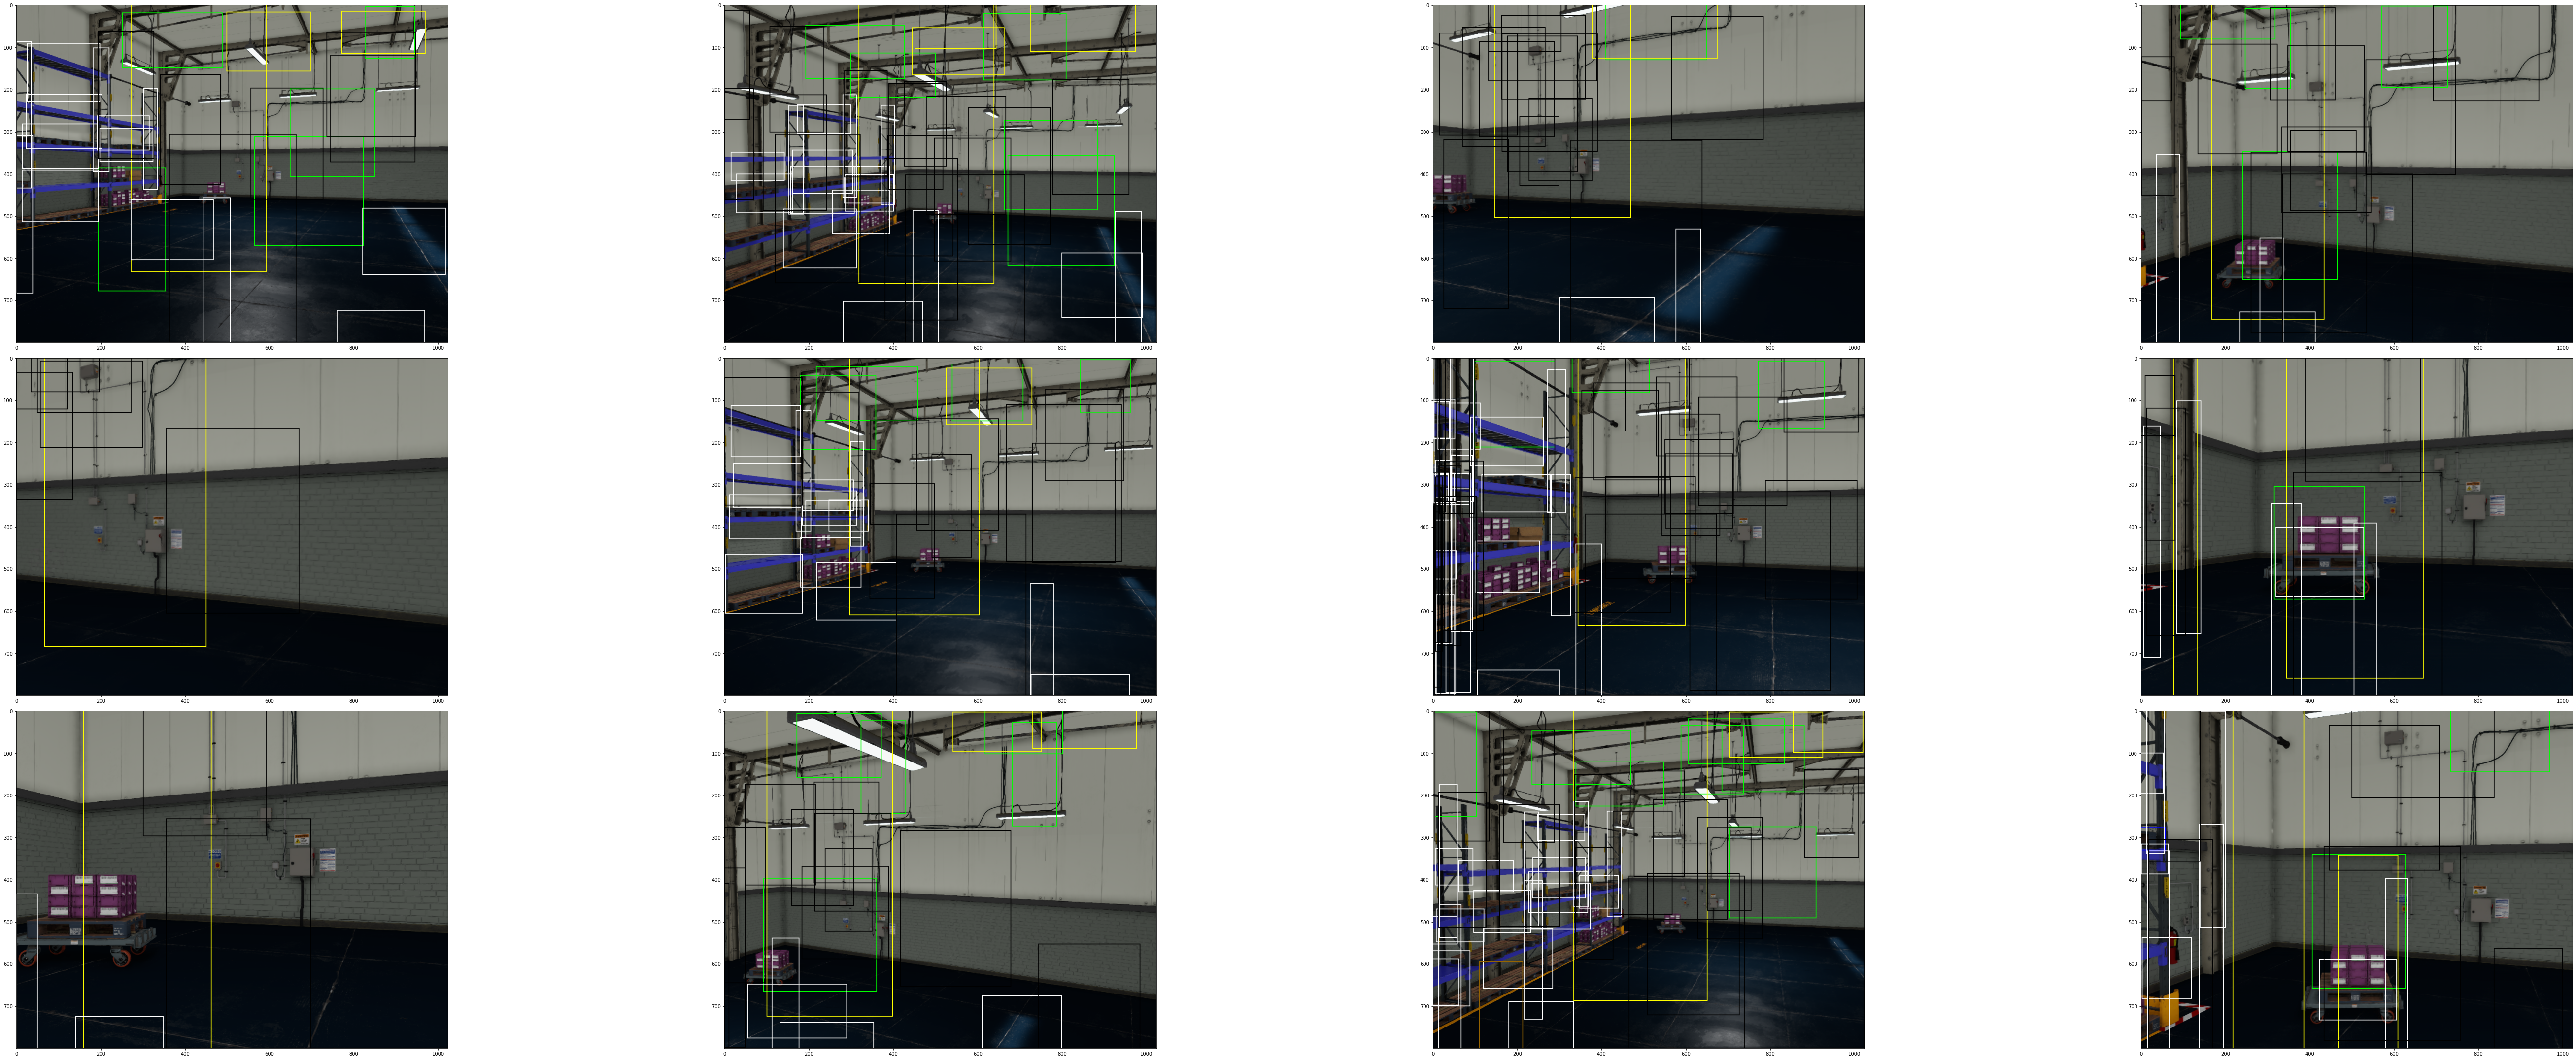

In [44]:
# Visualizing the first 12 images.
OUTPUT_PATH = 'tlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 10. Model Export <a class="anchor" id="head-10"></a>

In [ ]:
!mkdir -p $LOCAL_EXPERIMENT_DIR/experiment_dir_final
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'],
                         "experiment_dir_final/resnet18_detector.etlt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))
!tao detectnet_v2 export \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
                  -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
                  -k $KEY

In [ ]:
print('Exported model:')
print('------------')
!ls -lh $LOCAL_EXPERIMENT_DIR/experiment_dir_final

### A. Int8 Optimization <a class="anchor" id="head-10-1"></a>
DetectNet_v2 model supports int8 inference mode in TensorRT. 
In order to use int8 mode, we must calibrate the model to run 8-bit inferences -

* Generate calibration tensorfile from the training data using detectnet_v2 calibration_tensorfile
* Use tao <task> export to generate int8 calibration table.

*Note: For this example, we generate a calibration tensorfile containing 10 batches of training data.
Ideally, it is best to use atleast 10-20% of the training data to do so. The more data provided during calibration, the closer int8 inferences are to fp32 inferences.*

*Note: If the model was trained with QAT nodes available, please refrain from using the post training int8 optimization as mentioned below. Please export the model in int8 mode (using the arg `--data_type int8`) with just the path to the calibration cache file (using the argument `--cal_cache_file`)*

In [ ]:
!tao detectnet_v2 calibration_tensorfile -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                                         -m 10 \
                                         -o $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor

In [ ]:
!rm -rf $LOCAL_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt
!rm -rf $LOCAL_EXPERIMENT_DIR/experiment_dir_final/calibration.bin
!tao detectnet_v2 export \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
                  -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
                  -k $KEY  \
                  --cal_data_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor \
                  --data_type int8 \
                  --batches 10 \
                  --batch_size 4 \
                  --max_batch_size 4\
                  --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt.int8 \
                  --cal_cache_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
                  --verbose

### B. Generate TensorRT engine <a class="anchor" id="head-10-2"></a>
Verify engine generation using the `tao-converter` utility included with the docker.

The `tao-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tao-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The tao-converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the tao-converter for jetson from the dev zone link [here](https://developer.nvidia.com/tao-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [ ]:
!tao converter $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
                   -k $KEY \
                    -c $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
                   -o output_cov/Sigmoid,output_bbox/BiasAdd \
                   -d 3,384,1248 \
                   -i nchw \
                   -m 64 \
                   -t int8 \
                   -e $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt \
                   -b 4

## 11. Verify Deployed Model <a class="anchor" id="head-11"></a>
Verify the exported model by visualizing inferences on TensorRT.
In addition to running inference on a `.tlt` model in [step 9](#head-9), the `inference` tool is also capable of consuming the converted `TensorRT engine` from [step 10.B](#head-10-2).

*If after int-8 calibration the accuracy of the int-8 inferences seem to degrade, it could be because the there wasn't enough data in the calibration tensorfile used to calibrate thee model or, the training data is not entirely representative of your test images, and the calibration maybe incorrect. Therefore, you may either regenerate the calibration tensorfile with more batches of the training data and recalibrate the model, or calibrate the model on a few images from the test set. This may be done using `--cal_image_dir` flag in the `export` tool. For more information, please follow the instructions in the USER GUIDE.

### A. Inference using TensorRT engine <a class="anchor" id="head-11-1"></a>

In [ ]:
!tao detectnet_v2 inference -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt.txt \
                            -o $USER_EXPERIMENT_DIR/etlt_infer_testing \
                            -i $DATA_DOWNLOAD_DIR/testing/image_2 \
                            -k $KEY

In [ ]:
# visualize the first 12 inferenced images.
OUTPUT_PATH = 'etlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 11. QAT workflow <a class="anchor" id="head-12"></a>
This section delves into the newly enabled Quantization Aware Training feature with DetectNet_v2. The workflow defined below converts a pruned model from section [5](#head-5) to enable QAT and retrain this model to while accounting the noise introduced due to quantization in the forward pass. 

### A. Convert pruned model to QAT and retrain <a class="anchor" id="head-12-1"></a>
All detectnet models, unpruned and pruned models can be converted to QAT models by setting the `enable_qat` parameter in the `training_config` component of the spec file to `true`.

In [ ]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to convert the
# pretrained model to qat mode by setting the enable_qat
# parameter.
!cat $LOCAL_SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt

In [ ]:
!tao detectnet_v2 train -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_retrain_qat \
                        -k $KEY \
                        -n resnet18_detector_pruned_qat \
                        --gpus $NUM_GPUS

In [ ]:
!ls -rlt $LOCAL_EXPERIMENT_DIR/experiment_dir_retrain_qat/weights

### B. Evaluate QAT converted model <a class="anchor" id="head-12-2"></a>
This section evaluates a QAT enabled pruned retrained model. The mAP of this model should be comparable to that of the pruned retrained model without QAT. However, due to quantization, it is possible sometimes to see a drop in the mAP value for certain datasets.

In [ ]:
!tao detectnet_v2 evaluate -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_retrain_qat/weights/resnet18_detector_pruned_qat.tlt \
                           -k $KEY \
                           -f tlt

### C. Export QAT trained model to int8 <a class="anchor" id="head-12-3"></a>
Export a QAT trained model to TensorRT parsable model. This command generates an .etlt file from the trained model and the serializes corresponding int8 scales as a TRT readable calibration cache file.

In [ ]:
!rm -rf $LOCAL_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.etlt
!rm -rf $LOCAL_EXPERIMENT_DIR/experiment_dir_final/calibration_qat.bin
!tao detectnet_v2 export \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_retrain_qat/weights/resnet18_detector_pruned_qat.tlt \
                  -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.etlt \
                  -k $KEY  \
                  --data_type int8 \
                  --batch_size 64 \
                  --max_batch_size 64\
                  --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.trt.int8 \
                  --cal_cache_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration_qat.bin \
                  --verbose

### D. Evaluate a QAT trained model using the exported TensorRT engine <a class="anchor" id="head-12-4"></a>
This section evaluates a QAT enabled pruned retrained model using the TensorRT int8 engine that was exported in [Section C](#head-12-3). Please note that there maybe a slight difference (~0.1-0.5%) in the mAP from [Section B](#head-12-2), oweing to some differences in the implementation of quantization in TensorRT.

*Note: The TensorRT evaluator might be slightly slower than the TAO evaluator here, because the evaluation dataloader is pinned to the CPU to avoid any clashes between TensorRT and TAO instances in the GPU. Please note that this tool was not intended and has not been developed for profiling the model. It is just a means to qualitatively analyse the model.*

*Please use native TensorRT or DeepStream for the most optimized inferences.*

In [ ]:
!tao detectnet_v2 evaluate -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.trt.int8 \
                           -f tensorrt

### E. Inference using QAT engine <a class="anchor" id="head-12-5"></a>
Run inference and visualize detections on test images, using the exported TensorRT engine from [Section C](#head-12-3).

In [ ]:
!tao detectnet_v2 inference -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt_qat.txt \
                            -o $USER_EXPERIMENT_DIR/tlt_infer_testing_qat \
                            -i $DATA_DOWNLOAD_DIR/testing/image_2 \
                            -k $KEY

In [ ]:
# visualize the first 12 inferenced images.
OUTPUT_PATH = 'tlt_infer_testing_qat/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)